In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
from scipy.io import wavfile
fs, data = wavfile.read('genres/country/country.00000.wav')

In [21]:
genre_list = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [32]:
y, sr = librosa.load('genres/blues/blues.00000.wav')
spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max)

In [72]:
y1, sr1 = librosa.load('genres/disco/disco.00001.wav')
spect1 = librosa.feature.melspectrogram(y=y1, sr=sr1,n_fft=2048, hop_length=512)
spect1 = librosa.power_to_db(spect1, ref=np.max)

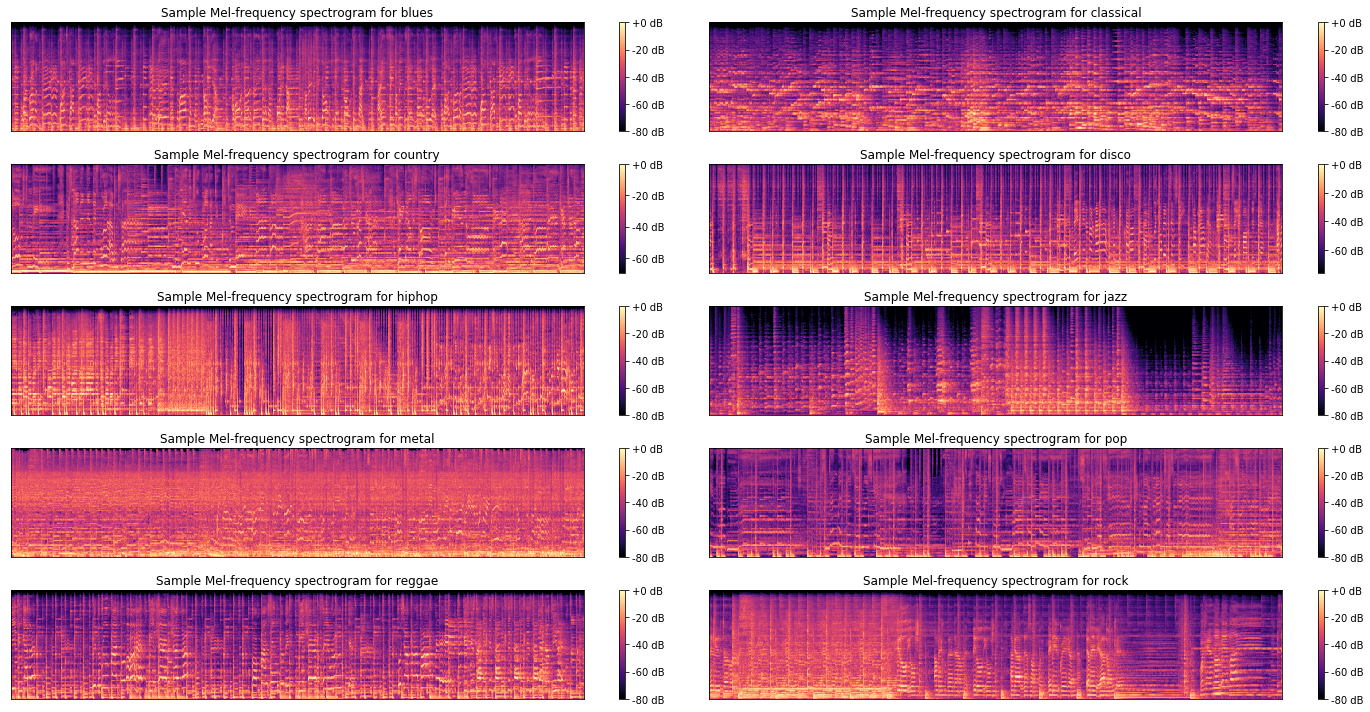

In [39]:
plt.figure(figsize=(20,10))
k = 1
for i in genre_list:
    y, sr = librosa.load('genres/{}/{}.00000.wav'.format(i,i))
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    spect = librosa.power_to_db(spect, ref=np.max)
    #plt.figure(figsize=(25, 8))
    
    # librosa.display.specshow(spect, x_axis='time',
    #                            y_axis='mel', sr=sr,
    #                           fmax=8000,)

    
    plt.subplot(5,2,k)l.
    librosa.display.specshow(spect,  sr=sr,
    fmax=8000,)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Sample Mel-frequency spectrogram for {}'.format(i))
    k += 1
plt.tight_layout()
plt.show()

In [10]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D
from keras.utils.np_utils import to_categorical
#https://medium.com/@navdeepsingh_2336/identifying-the-genre-of-a-song-with-neural-networks-851db89c42f0

Using TensorFlow backend.
/Users/zhuangdiezhou/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhuangdiezhou/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhuangdiezhou/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhuangdiezhou/anaconda3/l

In [11]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)
    
    plt.figure(figsize = (10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis = 'mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

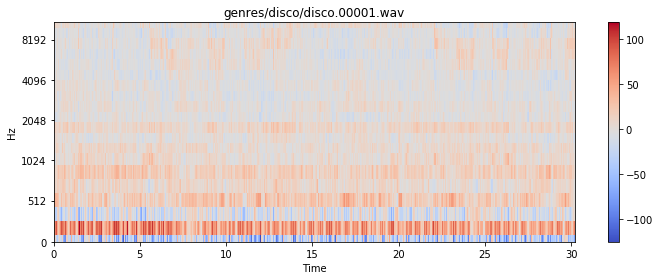

In [12]:
display_mfcc('genres/disco/disco.00001.wav')

In [13]:
def extract_features_song(f):
    y, _ = librosa.load(f)
    mfcc = librosa.feature.mfcc(y)
    mfcc /= np.amax(np.abs(mfcc))
    return np.ndarray.flatten(mfcc)[:25800]

In [14]:
def generate_features_and_labels():
    all_features = []
    all_labels = []
    
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre + '/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files),genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)
            
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse = True)
    label_row_ids = label_row_ids.astype(np.int32, copy = False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels
    #return all_features, onehot_labels

In [18]:
features, labels = generate_features_and_labels()
#all_features,  labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [19]:
print(features.shape)
print(labels.shape)

training_split = 0.8
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata)*training_split)
train, test = alldata[:splitidx, :], alldata[splitidx:, :]

print(train.shape)
print(test.shape)
train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(train_input.shape)
print(train_labels.shape)

(1000, 25800)
(1000, 10)
(800, 25810)
(200, 25810)
(800, 25800)
(800, 10)


In [20]:
model = Sequential([
    Dense(1000, input_dim = train_input.shape[1]),
    Activation('relu'),
    Dropout(0.2),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
print(model.summary())
model.fit(train_input,train_labels, epochs = 100, batch_size = 32, validation_split = 0.2)
loss, acc = model.evaluate(test_input, test_labels, batch_size = 32)
print('Done!')
print('Loss: %.4f, accuracy:%.4f'%(loss, acc))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              25801000  
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               100100    
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)      

In [21]:
acc

0.47

In [9]:
#https://github.com/ruohoruotsi/LSTM-Music-Genre-Classification/blob/master/lstm_genre_classifier_keras.py
import librosa
import math
import os
import re

import numpy as np


class GenreFeatureData:

    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "blues",
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
        "rock"
    ]

#     dir_trainfolder = "./gtzan/_train"
#     dir_devfolder = "./gtzan/_validation"
#     dir_testfolder = "./gtzan/_test"
    
    
    dir_all_files = "./genres2"
    
    dir_folder = []
    
    for i in genre_list:
        dir_genre = dir_all_files + '/'+i
        dir_folder.append(dir_genre)
        

    train_X_preprocessed_data = "./gtzan/data_train_input.npy"
    train_Y_preprocessed_data = "./gtzan/data_train_target.npy"
    dev_X_preprocessed_data = "./gtzan/data_validation_input.npy"
    dev_Y_preprocessed_data = "./gtzan/data_validation_target.npy"
    test_X_preprocessed_data = "./gtzan/data_test_input.npy"
    test_Y_preprocessed_data = "./gtzan/data_test_target.npy"

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = []
        self.devfiles_list = []
        self.testfiles_list = []
        
        for dir_ in self.dir_folder:
            files = self.path_to_audiofiles(dir_)
            self.trainfiles_list.extend(files[0:64*30])
            self.devfiles_list.extend(files[64*30:80*30])
            self.testfiles_list.extend(files[80*30:100*30])
        
        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)
        
        # compute minimum timeseries length, slow to compute, caching pre-computed value of 1290
        # self.precompute_min_timeseries_len()
        # print("min(self.timeseries_length_list) ==" + str(min(self.timeseries_length_list)))
        # self.timeseries_length = min(self.timeseries_length_list)

        self.timeseries_length = (
            30
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio, which is a bit small!

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))

        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        
        
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):

        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)
        #self.train_Y = self.one_hot(self.train_Y)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)
        #self.dev_Y = self.one_hot(self.dev_Y)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)
        #self.test_Y = self.one_hot(self.test_Y)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            print("Loading " + str(file))
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))

    def extract_audio_features(self, list_of_audiofiles):

        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, 40), dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[1])[3]
            target.append(genre)

            data[i, :, 0:20] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 20:21] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 21:33] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 33:40] = spectral_contrast.T[0:self.timeseries_length, :]
            
            #Normalize the data column wise 
            data = (data - np.mean(data,axis = 0)) / np.std(data,axis = 0)
            
            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )
        
        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".wav"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [10]:
import logging
import os
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam,SGD,RMSprop
from keras import regularizers

# from GenreFeatureData import (
#     GenreFeatureData,
# )  # local python class with Audio feature extraction (librosa)

# set logging level
logging.getLogger("tensorflow").setLevel(logging.ERROR)

genre_features = GenreFeatureData()

#if all of the preprocessed files do not exist, regenerate them all for self-consistency
if (
    os.path.isfile(genre_features.train_X_preprocessed_data)
    and os.path.isfile(genre_features.train_Y_preprocessed_data)
    and os.path.isfile(genre_features.dev_X_preprocessed_data)
    and os.path.isfile(genre_features.dev_Y_preprocessed_data)
    and os.path.isfile(genre_features.test_X_preprocessed_data)
    and os.path.isfile(genre_features.test_Y_preprocessed_data)
):
    print("Preprocessed files exist, deserializing npy files")
    genre_features.load_deserialize_data()
else:
    print("Preprocessing raw audio files")
    genre_features.load_preprocess_data()
#genre_features.load_preprocess_data()

print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
print("Dev X shape: " + str(genre_features.dev_X.shape))
print("Dev Y shape: " + str(genre_features.dev_Y.shape))
print("Test X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))

input_shape = (genre_features.train_X.shape[1], genre_features.train_X.shape[2])
print("Build LSTM RNN model ...")
model = Sequential()

#model.add(LSTM(units=256, dropout=0.5, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01),return_sequences=True, input_shape=input_shape))
# model.add(LSTM(units=128,  dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01),return_sequences=True))
# model.add(LSTM(units=64,  dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01),return_sequences=True))
# model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01),return_sequences=False))
#model.add(Dense(units=genre_features.train_Y.shape[1], activation="softmax"))

#model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.1,kernel_regularizer=regularizers.l2(0.01),input_shape=input_shape))

model.add(LSTM(units=128, dropout=0.5, recurrent_dropout=0.35, kernel_regularizer=regularizers.l2(0.01), return_sequences=True, input_shape=input_shape))
model.add(LSTM(units=64,  dropout=0.5, recurrent_dropout=0.35,kernel_regularizer=regularizers.l2(0.01), return_sequences=False))
model.add(Dense(units=genre_features.train_Y.shape[1], activation="softmax"))



print("Compiling ...")
# Keras optimizer defaults:
# Adam   : lr=0.001, beta_1=0.9,  beta_2=0.999, epsilon=1e-8, decay=0.
# RMSprop: lr=0.001, rho=0.9,                   epsilon=1e-8, decay=0.
# SGD    : lr=0.01,  momentum=0.,                             decay=0.

opt = Adam()
#opt = RMSprop()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

print("Training ...")
batch_size = 35  # num of training examples per minibatch
num_epochs = 400
model.fit(
    genre_features.train_X,
    genre_features.train_Y,
    batch_size=batch_size,
    epochs=num_epochs,
)

print("\nValidating ...")
score, accuracy = model.evaluate(
    genre_features.dev_X, genre_features.dev_Y, batch_size=batch_size, verbose=1
)
print("Dev loss:  ", score)
print("Dev accuracy:  ", accuracy)


print("\nTesting ...")
score, accuracy = model.evaluate(
    genre_features.test_X, genre_features.test_Y, batch_size=batch_size, verbose=1
)
print("Test loss:  ", score)
print("Test accuracy:  ", accuracy)

# Creates a HDF5 file 'lstm_genre_classifier.h5'
model_filename = "lstm_genre_classifier_lstm.h5"
print("\nSaving model: " + model_filename)
model.save(model_filename)

Preprocessing raw audio files
[DEBUG] total number of files: 0
Extracted features audio track 1 of 19200.
Extracted features audio track 2 of 19200.
Extracted features audio track 3 of 19200.
Extracted features audio track 4 of 19200.
Extracted features audio track 5 of 19200.
Extracted features audio track 6 of 19200.
Extracted features audio track 7 of 19200.
Extracted features audio track 8 of 19200.
Extracted features audio track 9 of 19200.
Extracted features audio track 10 of 19200.
Extracted features audio track 11 of 19200.
Extracted features audio track 12 of 19200.
Extracted features audio track 13 of 19200.
Extracted features audio track 14 of 19200.
Extracted features audio track 15 of 19200.
Extracted features audio track 16 of 19200.
Extracted features audio track 17 of 19200.
Extracted features audio track 18 of 19200.
Extracted features audio track 19 of 19200.
Extracted features audio track 20 of 19200.
Extracted features audio track 21 of 19200.
Extracted features aud

Extracted features audio track 185 of 19200.
Extracted features audio track 186 of 19200.
Extracted features audio track 187 of 19200.
Extracted features audio track 188 of 19200.
Extracted features audio track 189 of 19200.
Extracted features audio track 190 of 19200.
Extracted features audio track 191 of 19200.
Extracted features audio track 192 of 19200.
Extracted features audio track 193 of 19200.
Extracted features audio track 194 of 19200.
Extracted features audio track 195 of 19200.
Extracted features audio track 196 of 19200.
Extracted features audio track 197 of 19200.
Extracted features audio track 198 of 19200.
Extracted features audio track 199 of 19200.
Extracted features audio track 200 of 19200.
Extracted features audio track 201 of 19200.
Extracted features audio track 202 of 19200.
Extracted features audio track 203 of 19200.
Extracted features audio track 204 of 19200.
Extracted features audio track 205 of 19200.
Extracted features audio track 206 of 19200.
Extracted 

Extracted features audio track 368 of 19200.
Extracted features audio track 369 of 19200.
Extracted features audio track 370 of 19200.
Extracted features audio track 371 of 19200.
Extracted features audio track 372 of 19200.
Extracted features audio track 373 of 19200.
Extracted features audio track 374 of 19200.
Extracted features audio track 375 of 19200.
Extracted features audio track 376 of 19200.
Extracted features audio track 377 of 19200.
Extracted features audio track 378 of 19200.
Extracted features audio track 379 of 19200.
Extracted features audio track 380 of 19200.
Extracted features audio track 381 of 19200.
Extracted features audio track 382 of 19200.
Extracted features audio track 383 of 19200.
Extracted features audio track 384 of 19200.
Extracted features audio track 385 of 19200.
Extracted features audio track 386 of 19200.
Extracted features audio track 387 of 19200.
Extracted features audio track 388 of 19200.
Extracted features audio track 389 of 19200.
Extracted 

Extracted features audio track 551 of 19200.
Extracted features audio track 552 of 19200.
Extracted features audio track 553 of 19200.
Extracted features audio track 554 of 19200.
Extracted features audio track 555 of 19200.
Extracted features audio track 556 of 19200.
Extracted features audio track 557 of 19200.
Extracted features audio track 558 of 19200.
Extracted features audio track 559 of 19200.
Extracted features audio track 560 of 19200.
Extracted features audio track 561 of 19200.
Extracted features audio track 562 of 19200.
Extracted features audio track 563 of 19200.
Extracted features audio track 564 of 19200.
Extracted features audio track 565 of 19200.
Extracted features audio track 566 of 19200.
Extracted features audio track 567 of 19200.
Extracted features audio track 568 of 19200.
Extracted features audio track 569 of 19200.
Extracted features audio track 570 of 19200.
Extracted features audio track 571 of 19200.
Extracted features audio track 572 of 19200.
Extracted 

Extracted features audio track 734 of 19200.
Extracted features audio track 735 of 19200.
Extracted features audio track 736 of 19200.
Extracted features audio track 737 of 19200.
Extracted features audio track 738 of 19200.
Extracted features audio track 739 of 19200.
Extracted features audio track 740 of 19200.
Extracted features audio track 741 of 19200.
Extracted features audio track 742 of 19200.
Extracted features audio track 743 of 19200.
Extracted features audio track 744 of 19200.
Extracted features audio track 745 of 19200.
Extracted features audio track 746 of 19200.
Extracted features audio track 747 of 19200.
Extracted features audio track 748 of 19200.
Extracted features audio track 749 of 19200.
Extracted features audio track 750 of 19200.
Extracted features audio track 751 of 19200.
Extracted features audio track 752 of 19200.
Extracted features audio track 753 of 19200.
Extracted features audio track 754 of 19200.
Extracted features audio track 755 of 19200.
Extracted 

Extracted features audio track 917 of 19200.
Extracted features audio track 918 of 19200.
Extracted features audio track 919 of 19200.
Extracted features audio track 920 of 19200.
Extracted features audio track 921 of 19200.
Extracted features audio track 922 of 19200.
Extracted features audio track 923 of 19200.
Extracted features audio track 924 of 19200.
Extracted features audio track 925 of 19200.
Extracted features audio track 926 of 19200.
Extracted features audio track 927 of 19200.
Extracted features audio track 928 of 19200.
Extracted features audio track 929 of 19200.
Extracted features audio track 930 of 19200.
Extracted features audio track 931 of 19200.
Extracted features audio track 932 of 19200.
Extracted features audio track 933 of 19200.
Extracted features audio track 934 of 19200.
Extracted features audio track 935 of 19200.
Extracted features audio track 936 of 19200.
Extracted features audio track 937 of 19200.
Extracted features audio track 938 of 19200.
Extracted 

Extracted features audio track 1097 of 19200.
Extracted features audio track 1098 of 19200.
Extracted features audio track 1099 of 19200.
Extracted features audio track 1100 of 19200.
Extracted features audio track 1101 of 19200.
Extracted features audio track 1102 of 19200.
Extracted features audio track 1103 of 19200.
Extracted features audio track 1104 of 19200.
Extracted features audio track 1105 of 19200.
Extracted features audio track 1106 of 19200.
Extracted features audio track 1107 of 19200.
Extracted features audio track 1108 of 19200.
Extracted features audio track 1109 of 19200.
Extracted features audio track 1110 of 19200.
Extracted features audio track 1111 of 19200.
Extracted features audio track 1112 of 19200.
Extracted features audio track 1113 of 19200.
Extracted features audio track 1114 of 19200.
Extracted features audio track 1115 of 19200.
Extracted features audio track 1116 of 19200.
Extracted features audio track 1117 of 19200.
Extracted features audio track 111

Extracted features audio track 1276 of 19200.
Extracted features audio track 1277 of 19200.
Extracted features audio track 1278 of 19200.
Extracted features audio track 1279 of 19200.
Extracted features audio track 1280 of 19200.
Extracted features audio track 1281 of 19200.
Extracted features audio track 1282 of 19200.
Extracted features audio track 1283 of 19200.
Extracted features audio track 1284 of 19200.
Extracted features audio track 1285 of 19200.
Extracted features audio track 1286 of 19200.
Extracted features audio track 1287 of 19200.
Extracted features audio track 1288 of 19200.
Extracted features audio track 1289 of 19200.
Extracted features audio track 1290 of 19200.
Extracted features audio track 1291 of 19200.
Extracted features audio track 1292 of 19200.
Extracted features audio track 1293 of 19200.
Extracted features audio track 1294 of 19200.
Extracted features audio track 1295 of 19200.
Extracted features audio track 1296 of 19200.
Extracted features audio track 129

Extracted features audio track 1455 of 19200.
Extracted features audio track 1456 of 19200.
Extracted features audio track 1457 of 19200.
Extracted features audio track 1458 of 19200.
Extracted features audio track 1459 of 19200.
Extracted features audio track 1460 of 19200.
Extracted features audio track 1461 of 19200.
Extracted features audio track 1462 of 19200.
Extracted features audio track 1463 of 19200.
Extracted features audio track 1464 of 19200.
Extracted features audio track 1465 of 19200.
Extracted features audio track 1466 of 19200.
Extracted features audio track 1467 of 19200.
Extracted features audio track 1468 of 19200.
Extracted features audio track 1469 of 19200.
Extracted features audio track 1470 of 19200.
Extracted features audio track 1471 of 19200.
Extracted features audio track 1472 of 19200.
Extracted features audio track 1473 of 19200.
Extracted features audio track 1474 of 19200.
Extracted features audio track 1475 of 19200.
Extracted features audio track 147

Extracted features audio track 1634 of 19200.
Extracted features audio track 1635 of 19200.
Extracted features audio track 1636 of 19200.
Extracted features audio track 1637 of 19200.
Extracted features audio track 1638 of 19200.
Extracted features audio track 1639 of 19200.
Extracted features audio track 1640 of 19200.
Extracted features audio track 1641 of 19200.
Extracted features audio track 1642 of 19200.
Extracted features audio track 1643 of 19200.
Extracted features audio track 1644 of 19200.
Extracted features audio track 1645 of 19200.
Extracted features audio track 1646 of 19200.
Extracted features audio track 1647 of 19200.
Extracted features audio track 1648 of 19200.
Extracted features audio track 1649 of 19200.
Extracted features audio track 1650 of 19200.
Extracted features audio track 1651 of 19200.
Extracted features audio track 1652 of 19200.
Extracted features audio track 1653 of 19200.
Extracted features audio track 1654 of 19200.
Extracted features audio track 165

Extracted features audio track 1813 of 19200.
Extracted features audio track 1814 of 19200.
Extracted features audio track 1815 of 19200.
Extracted features audio track 1816 of 19200.
Extracted features audio track 1817 of 19200.
Extracted features audio track 1818 of 19200.
Extracted features audio track 1819 of 19200.
Extracted features audio track 1820 of 19200.
Extracted features audio track 1821 of 19200.
Extracted features audio track 1822 of 19200.
Extracted features audio track 1823 of 19200.
Extracted features audio track 1824 of 19200.
Extracted features audio track 1825 of 19200.
Extracted features audio track 1826 of 19200.
Extracted features audio track 1827 of 19200.
Extracted features audio track 1828 of 19200.
Extracted features audio track 1829 of 19200.
Extracted features audio track 1830 of 19200.
Extracted features audio track 1831 of 19200.
Extracted features audio track 1832 of 19200.
Extracted features audio track 1833 of 19200.
Extracted features audio track 183

Extracted features audio track 1992 of 19200.
Extracted features audio track 1993 of 19200.
Extracted features audio track 1994 of 19200.
Extracted features audio track 1995 of 19200.
Extracted features audio track 1996 of 19200.
Extracted features audio track 1997 of 19200.
Extracted features audio track 1998 of 19200.
Extracted features audio track 1999 of 19200.
Extracted features audio track 2000 of 19200.
Extracted features audio track 2001 of 19200.
Extracted features audio track 2002 of 19200.
Extracted features audio track 2003 of 19200.
Extracted features audio track 2004 of 19200.
Extracted features audio track 2005 of 19200.
Extracted features audio track 2006 of 19200.
Extracted features audio track 2007 of 19200.
Extracted features audio track 2008 of 19200.
Extracted features audio track 2009 of 19200.
Extracted features audio track 2010 of 19200.
Extracted features audio track 2011 of 19200.
Extracted features audio track 2012 of 19200.
Extracted features audio track 201

Extracted features audio track 2171 of 19200.
Extracted features audio track 2172 of 19200.
Extracted features audio track 2173 of 19200.
Extracted features audio track 2174 of 19200.
Extracted features audio track 2175 of 19200.
Extracted features audio track 2176 of 19200.
Extracted features audio track 2177 of 19200.
Extracted features audio track 2178 of 19200.
Extracted features audio track 2179 of 19200.
Extracted features audio track 2180 of 19200.
Extracted features audio track 2181 of 19200.
Extracted features audio track 2182 of 19200.
Extracted features audio track 2183 of 19200.
Extracted features audio track 2184 of 19200.
Extracted features audio track 2185 of 19200.
Extracted features audio track 2186 of 19200.
Extracted features audio track 2187 of 19200.
Extracted features audio track 2188 of 19200.
Extracted features audio track 2189 of 19200.
Extracted features audio track 2190 of 19200.
Extracted features audio track 2191 of 19200.
Extracted features audio track 219

Extracted features audio track 2350 of 19200.
Extracted features audio track 2351 of 19200.
Extracted features audio track 2352 of 19200.
Extracted features audio track 2353 of 19200.
Extracted features audio track 2354 of 19200.
Extracted features audio track 2355 of 19200.
Extracted features audio track 2356 of 19200.
Extracted features audio track 2357 of 19200.
Extracted features audio track 2358 of 19200.
Extracted features audio track 2359 of 19200.
Extracted features audio track 2360 of 19200.
Extracted features audio track 2361 of 19200.
Extracted features audio track 2362 of 19200.
Extracted features audio track 2363 of 19200.
Extracted features audio track 2364 of 19200.
Extracted features audio track 2365 of 19200.
Extracted features audio track 2366 of 19200.
Extracted features audio track 2367 of 19200.
Extracted features audio track 2368 of 19200.
Extracted features audio track 2369 of 19200.
Extracted features audio track 2370 of 19200.
Extracted features audio track 237

Extracted features audio track 2529 of 19200.
Extracted features audio track 2530 of 19200.
Extracted features audio track 2531 of 19200.
Extracted features audio track 2532 of 19200.
Extracted features audio track 2533 of 19200.
Extracted features audio track 2534 of 19200.
Extracted features audio track 2535 of 19200.
Extracted features audio track 2536 of 19200.
Extracted features audio track 2537 of 19200.
Extracted features audio track 2538 of 19200.
Extracted features audio track 2539 of 19200.
Extracted features audio track 2540 of 19200.
Extracted features audio track 2541 of 19200.
Extracted features audio track 2542 of 19200.
Extracted features audio track 2543 of 19200.
Extracted features audio track 2544 of 19200.
Extracted features audio track 2545 of 19200.
Extracted features audio track 2546 of 19200.
Extracted features audio track 2547 of 19200.
Extracted features audio track 2548 of 19200.
Extracted features audio track 2549 of 19200.
Extracted features audio track 255

Extracted features audio track 2708 of 19200.
Extracted features audio track 2709 of 19200.
Extracted features audio track 2710 of 19200.
Extracted features audio track 2711 of 19200.
Extracted features audio track 2712 of 19200.
Extracted features audio track 2713 of 19200.
Extracted features audio track 2714 of 19200.
Extracted features audio track 2715 of 19200.
Extracted features audio track 2716 of 19200.
Extracted features audio track 2717 of 19200.
Extracted features audio track 2718 of 19200.
Extracted features audio track 2719 of 19200.
Extracted features audio track 2720 of 19200.
Extracted features audio track 2721 of 19200.
Extracted features audio track 2722 of 19200.
Extracted features audio track 2723 of 19200.
Extracted features audio track 2724 of 19200.
Extracted features audio track 2725 of 19200.
Extracted features audio track 2726 of 19200.
Extracted features audio track 2727 of 19200.
Extracted features audio track 2728 of 19200.
Extracted features audio track 272

Extracted features audio track 2887 of 19200.
Extracted features audio track 2888 of 19200.
Extracted features audio track 2889 of 19200.
Extracted features audio track 2890 of 19200.
Extracted features audio track 2891 of 19200.
Extracted features audio track 2892 of 19200.
Extracted features audio track 2893 of 19200.
Extracted features audio track 2894 of 19200.
Extracted features audio track 2895 of 19200.
Extracted features audio track 2896 of 19200.
Extracted features audio track 2897 of 19200.
Extracted features audio track 2898 of 19200.
Extracted features audio track 2899 of 19200.
Extracted features audio track 2900 of 19200.
Extracted features audio track 2901 of 19200.
Extracted features audio track 2902 of 19200.
Extracted features audio track 2903 of 19200.
Extracted features audio track 2904 of 19200.
Extracted features audio track 2905 of 19200.
Extracted features audio track 2906 of 19200.
Extracted features audio track 2907 of 19200.
Extracted features audio track 290

Extracted features audio track 3066 of 19200.
Extracted features audio track 3067 of 19200.
Extracted features audio track 3068 of 19200.
Extracted features audio track 3069 of 19200.
Extracted features audio track 3070 of 19200.
Extracted features audio track 3071 of 19200.
Extracted features audio track 3072 of 19200.
Extracted features audio track 3073 of 19200.
Extracted features audio track 3074 of 19200.
Extracted features audio track 3075 of 19200.
Extracted features audio track 3076 of 19200.
Extracted features audio track 3077 of 19200.
Extracted features audio track 3078 of 19200.
Extracted features audio track 3079 of 19200.
Extracted features audio track 3080 of 19200.
Extracted features audio track 3081 of 19200.
Extracted features audio track 3082 of 19200.
Extracted features audio track 3083 of 19200.
Extracted features audio track 3084 of 19200.
Extracted features audio track 3085 of 19200.
Extracted features audio track 3086 of 19200.
Extracted features audio track 308

/Users/zhuangdiezhou/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Extracted features audio track 3102 of 19200.
Extracted features audio track 3103 of 19200.
Extracted features audio track 3104 of 19200.
Extracted features audio track 3105 of 19200.
Extracted features audio track 3106 of 19200.
Extracted features audio track 3107 of 19200.
Extracted features audio track 3108 of 19200.
Extracted features audio track 3109 of 19200.
Extracted features audio track 3110 of 19200.
Extracted features audio track 3111 of 19200.
Extracted features audio track 3112 of 19200.
Extracted features audio track 3113 of 19200.
Extracted features audio track 3114 of 19200.
Extracted features audio track 3115 of 19200.
Extracted features audio track 3116 of 19200.
Extracted features audio track 3117 of 19200.
Extracted features audio track 3118 of 19200.
Extracted features audio track 3119 of 19200.
Extracted features audio track 3120 of 19200.
Extracted features audio track 3121 of 19200.
Extracted features audio track 3122 of 19200.
Extracted features audio track 312

Extracted features audio track 3281 of 19200.
Extracted features audio track 3282 of 19200.
Extracted features audio track 3283 of 19200.
Extracted features audio track 3284 of 19200.
Extracted features audio track 3285 of 19200.
Extracted features audio track 3286 of 19200.
Extracted features audio track 3287 of 19200.
Extracted features audio track 3288 of 19200.
Extracted features audio track 3289 of 19200.
Extracted features audio track 3290 of 19200.
Extracted features audio track 3291 of 19200.
Extracted features audio track 3292 of 19200.
Extracted features audio track 3293 of 19200.
Extracted features audio track 3294 of 19200.
Extracted features audio track 3295 of 19200.
Extracted features audio track 3296 of 19200.
Extracted features audio track 3297 of 19200.
Extracted features audio track 3298 of 19200.
Extracted features audio track 3299 of 19200.
Extracted features audio track 3300 of 19200.
Extracted features audio track 3301 of 19200.
Extracted features audio track 330

Extracted features audio track 3460 of 19200.
Extracted features audio track 3461 of 19200.
Extracted features audio track 3462 of 19200.
Extracted features audio track 3463 of 19200.
Extracted features audio track 3464 of 19200.
Extracted features audio track 3465 of 19200.
Extracted features audio track 3466 of 19200.
Extracted features audio track 3467 of 19200.
Extracted features audio track 3468 of 19200.
Extracted features audio track 3469 of 19200.
Extracted features audio track 3470 of 19200.
Extracted features audio track 3471 of 19200.
Extracted features audio track 3472 of 19200.
Extracted features audio track 3473 of 19200.
Extracted features audio track 3474 of 19200.
Extracted features audio track 3475 of 19200.
Extracted features audio track 3476 of 19200.
Extracted features audio track 3477 of 19200.
Extracted features audio track 3478 of 19200.
Extracted features audio track 3479 of 19200.
Extracted features audio track 3480 of 19200.
Extracted features audio track 348

Extracted features audio track 3639 of 19200.
Extracted features audio track 3640 of 19200.
Extracted features audio track 3641 of 19200.
Extracted features audio track 3642 of 19200.
Extracted features audio track 3643 of 19200.
Extracted features audio track 3644 of 19200.
Extracted features audio track 3645 of 19200.
Extracted features audio track 3646 of 19200.
Extracted features audio track 3647 of 19200.
Extracted features audio track 3648 of 19200.
Extracted features audio track 3649 of 19200.
Extracted features audio track 3650 of 19200.
Extracted features audio track 3651 of 19200.
Extracted features audio track 3652 of 19200.
Extracted features audio track 3653 of 19200.
Extracted features audio track 3654 of 19200.
Extracted features audio track 3655 of 19200.
Extracted features audio track 3656 of 19200.
Extracted features audio track 3657 of 19200.
Extracted features audio track 3658 of 19200.
Extracted features audio track 3659 of 19200.
Extracted features audio track 366

Extracted features audio track 3818 of 19200.
Extracted features audio track 3819 of 19200.
Extracted features audio track 3820 of 19200.
Extracted features audio track 3821 of 19200.
Extracted features audio track 3822 of 19200.
Extracted features audio track 3823 of 19200.
Extracted features audio track 3824 of 19200.
Extracted features audio track 3825 of 19200.
Extracted features audio track 3826 of 19200.
Extracted features audio track 3827 of 19200.
Extracted features audio track 3828 of 19200.
Extracted features audio track 3829 of 19200.
Extracted features audio track 3830 of 19200.
Extracted features audio track 3831 of 19200.
Extracted features audio track 3832 of 19200.
Extracted features audio track 3833 of 19200.
Extracted features audio track 3834 of 19200.
Extracted features audio track 3835 of 19200.
Extracted features audio track 3836 of 19200.
Extracted features audio track 3837 of 19200.
Extracted features audio track 3838 of 19200.
Extracted features audio track 383

Extracted features audio track 3997 of 19200.
Extracted features audio track 3998 of 19200.
Extracted features audio track 3999 of 19200.
Extracted features audio track 4000 of 19200.
Extracted features audio track 4001 of 19200.
Extracted features audio track 4002 of 19200.
Extracted features audio track 4003 of 19200.
Extracted features audio track 4004 of 19200.
Extracted features audio track 4005 of 19200.
Extracted features audio track 4006 of 19200.
Extracted features audio track 4007 of 19200.
Extracted features audio track 4008 of 19200.
Extracted features audio track 4009 of 19200.
Extracted features audio track 4010 of 19200.
Extracted features audio track 4011 of 19200.
Extracted features audio track 4012 of 19200.
Extracted features audio track 4013 of 19200.
Extracted features audio track 4014 of 19200.
Extracted features audio track 4015 of 19200.
Extracted features audio track 4016 of 19200.
Extracted features audio track 4017 of 19200.
Extracted features audio track 401

Extracted features audio track 4176 of 19200.
Extracted features audio track 4177 of 19200.
Extracted features audio track 4178 of 19200.
Extracted features audio track 4179 of 19200.
Extracted features audio track 4180 of 19200.
Extracted features audio track 4181 of 19200.
Extracted features audio track 4182 of 19200.
Extracted features audio track 4183 of 19200.
Extracted features audio track 4184 of 19200.
Extracted features audio track 4185 of 19200.
Extracted features audio track 4186 of 19200.
Extracted features audio track 4187 of 19200.
Extracted features audio track 4188 of 19200.
Extracted features audio track 4189 of 19200.
Extracted features audio track 4190 of 19200.
Extracted features audio track 4191 of 19200.
Extracted features audio track 4192 of 19200.
Extracted features audio track 4193 of 19200.
Extracted features audio track 4194 of 19200.
Extracted features audio track 4195 of 19200.
Extracted features audio track 4196 of 19200.
Extracted features audio track 419

Extracted features audio track 4355 of 19200.
Extracted features audio track 4356 of 19200.
Extracted features audio track 4357 of 19200.
Extracted features audio track 4358 of 19200.
Extracted features audio track 4359 of 19200.
Extracted features audio track 4360 of 19200.
Extracted features audio track 4361 of 19200.
Extracted features audio track 4362 of 19200.
Extracted features audio track 4363 of 19200.
Extracted features audio track 4364 of 19200.
Extracted features audio track 4365 of 19200.
Extracted features audio track 4366 of 19200.
Extracted features audio track 4367 of 19200.
Extracted features audio track 4368 of 19200.
Extracted features audio track 4369 of 19200.
Extracted features audio track 4370 of 19200.
Extracted features audio track 4371 of 19200.
Extracted features audio track 4372 of 19200.
Extracted features audio track 4373 of 19200.
Extracted features audio track 4374 of 19200.
Extracted features audio track 4375 of 19200.
Extracted features audio track 437

Extracted features audio track 4534 of 19200.
Extracted features audio track 4535 of 19200.
Extracted features audio track 4536 of 19200.
Extracted features audio track 4537 of 19200.
Extracted features audio track 4538 of 19200.
Extracted features audio track 4539 of 19200.
Extracted features audio track 4540 of 19200.
Extracted features audio track 4541 of 19200.
Extracted features audio track 4542 of 19200.
Extracted features audio track 4543 of 19200.
Extracted features audio track 4544 of 19200.
Extracted features audio track 4545 of 19200.
Extracted features audio track 4546 of 19200.
Extracted features audio track 4547 of 19200.
Extracted features audio track 4548 of 19200.
Extracted features audio track 4549 of 19200.
Extracted features audio track 4550 of 19200.
Extracted features audio track 4551 of 19200.
Extracted features audio track 4552 of 19200.
Extracted features audio track 4553 of 19200.
Extracted features audio track 4554 of 19200.
Extracted features audio track 455

Extracted features audio track 4713 of 19200.
Extracted features audio track 4714 of 19200.
Extracted features audio track 4715 of 19200.
Extracted features audio track 4716 of 19200.
Extracted features audio track 4717 of 19200.
Extracted features audio track 4718 of 19200.
Extracted features audio track 4719 of 19200.
Extracted features audio track 4720 of 19200.
Extracted features audio track 4721 of 19200.
Extracted features audio track 4722 of 19200.
Extracted features audio track 4723 of 19200.
Extracted features audio track 4724 of 19200.
Extracted features audio track 4725 of 19200.
Extracted features audio track 4726 of 19200.
Extracted features audio track 4727 of 19200.
Extracted features audio track 4728 of 19200.
Extracted features audio track 4729 of 19200.
Extracted features audio track 4730 of 19200.
Extracted features audio track 4731 of 19200.
Extracted features audio track 4732 of 19200.
Extracted features audio track 4733 of 19200.
Extracted features audio track 473

Extracted features audio track 4892 of 19200.
Extracted features audio track 4893 of 19200.
Extracted features audio track 4894 of 19200.
Extracted features audio track 4895 of 19200.
Extracted features audio track 4896 of 19200.
Extracted features audio track 4897 of 19200.
Extracted features audio track 4898 of 19200.
Extracted features audio track 4899 of 19200.
Extracted features audio track 4900 of 19200.
Extracted features audio track 4901 of 19200.
Extracted features audio track 4902 of 19200.
Extracted features audio track 4903 of 19200.
Extracted features audio track 4904 of 19200.
Extracted features audio track 4905 of 19200.
Extracted features audio track 4906 of 19200.
Extracted features audio track 4907 of 19200.
Extracted features audio track 4908 of 19200.
Extracted features audio track 4909 of 19200.
Extracted features audio track 4910 of 19200.
Extracted features audio track 4911 of 19200.
Extracted features audio track 4912 of 19200.
Extracted features audio track 491

Extracted features audio track 5071 of 19200.
Extracted features audio track 5072 of 19200.
Extracted features audio track 5073 of 19200.
Extracted features audio track 5074 of 19200.
Extracted features audio track 5075 of 19200.
Extracted features audio track 5076 of 19200.
Extracted features audio track 5077 of 19200.
Extracted features audio track 5078 of 19200.
Extracted features audio track 5079 of 19200.
Extracted features audio track 5080 of 19200.
Extracted features audio track 5081 of 19200.
Extracted features audio track 5082 of 19200.
Extracted features audio track 5083 of 19200.
Extracted features audio track 5084 of 19200.
Extracted features audio track 5085 of 19200.
Extracted features audio track 5086 of 19200.
Extracted features audio track 5087 of 19200.
Extracted features audio track 5088 of 19200.
Extracted features audio track 5089 of 19200.
Extracted features audio track 5090 of 19200.
Extracted features audio track 5091 of 19200.
Extracted features audio track 509

Extracted features audio track 5250 of 19200.
Extracted features audio track 5251 of 19200.
Extracted features audio track 5252 of 19200.
Extracted features audio track 5253 of 19200.
Extracted features audio track 5254 of 19200.
Extracted features audio track 5255 of 19200.
Extracted features audio track 5256 of 19200.
Extracted features audio track 5257 of 19200.
Extracted features audio track 5258 of 19200.
Extracted features audio track 5259 of 19200.
Extracted features audio track 5260 of 19200.
Extracted features audio track 5261 of 19200.
Extracted features audio track 5262 of 19200.
Extracted features audio track 5263 of 19200.
Extracted features audio track 5264 of 19200.
Extracted features audio track 5265 of 19200.
Extracted features audio track 5266 of 19200.
Extracted features audio track 5267 of 19200.
Extracted features audio track 5268 of 19200.
Extracted features audio track 5269 of 19200.
Extracted features audio track 5270 of 19200.
Extracted features audio track 527

Extracted features audio track 5429 of 19200.
Extracted features audio track 5430 of 19200.
Extracted features audio track 5431 of 19200.
Extracted features audio track 5432 of 19200.
Extracted features audio track 5433 of 19200.
Extracted features audio track 5434 of 19200.
Extracted features audio track 5435 of 19200.
Extracted features audio track 5436 of 19200.
Extracted features audio track 5437 of 19200.
Extracted features audio track 5438 of 19200.
Extracted features audio track 5439 of 19200.
Extracted features audio track 5440 of 19200.
Extracted features audio track 5441 of 19200.
Extracted features audio track 5442 of 19200.
Extracted features audio track 5443 of 19200.
Extracted features audio track 5444 of 19200.
Extracted features audio track 5445 of 19200.
Extracted features audio track 5446 of 19200.
Extracted features audio track 5447 of 19200.
Extracted features audio track 5448 of 19200.
Extracted features audio track 5449 of 19200.
Extracted features audio track 545

Extracted features audio track 5608 of 19200.
Extracted features audio track 5609 of 19200.
Extracted features audio track 5610 of 19200.
Extracted features audio track 5611 of 19200.
Extracted features audio track 5612 of 19200.
Extracted features audio track 5613 of 19200.
Extracted features audio track 5614 of 19200.
Extracted features audio track 5615 of 19200.
Extracted features audio track 5616 of 19200.
Extracted features audio track 5617 of 19200.
Extracted features audio track 5618 of 19200.
Extracted features audio track 5619 of 19200.
Extracted features audio track 5620 of 19200.
Extracted features audio track 5621 of 19200.
Extracted features audio track 5622 of 19200.
Extracted features audio track 5623 of 19200.
Extracted features audio track 5624 of 19200.
Extracted features audio track 5625 of 19200.
Extracted features audio track 5626 of 19200.
Extracted features audio track 5627 of 19200.
Extracted features audio track 5628 of 19200.
Extracted features audio track 562

Extracted features audio track 5787 of 19200.
Extracted features audio track 5788 of 19200.
Extracted features audio track 5789 of 19200.
Extracted features audio track 5790 of 19200.
Extracted features audio track 5791 of 19200.
Extracted features audio track 5792 of 19200.
Extracted features audio track 5793 of 19200.
Extracted features audio track 5794 of 19200.
Extracted features audio track 5795 of 19200.
Extracted features audio track 5796 of 19200.
Extracted features audio track 5797 of 19200.
Extracted features audio track 5798 of 19200.
Extracted features audio track 5799 of 19200.
Extracted features audio track 5800 of 19200.
Extracted features audio track 5801 of 19200.
Extracted features audio track 5802 of 19200.
Extracted features audio track 5803 of 19200.
Extracted features audio track 5804 of 19200.
Extracted features audio track 5805 of 19200.
Extracted features audio track 5806 of 19200.
Extracted features audio track 5807 of 19200.
Extracted features audio track 580

Extracted features audio track 5966 of 19200.
Extracted features audio track 5967 of 19200.
Extracted features audio track 5968 of 19200.
Extracted features audio track 5969 of 19200.
Extracted features audio track 5970 of 19200.
Extracted features audio track 5971 of 19200.
Extracted features audio track 5972 of 19200.
Extracted features audio track 5973 of 19200.
Extracted features audio track 5974 of 19200.
Extracted features audio track 5975 of 19200.
Extracted features audio track 5976 of 19200.
Extracted features audio track 5977 of 19200.
Extracted features audio track 5978 of 19200.
Extracted features audio track 5979 of 19200.
Extracted features audio track 5980 of 19200.
Extracted features audio track 5981 of 19200.
Extracted features audio track 5982 of 19200.
Extracted features audio track 5983 of 19200.
Extracted features audio track 5984 of 19200.
Extracted features audio track 5985 of 19200.
Extracted features audio track 5986 of 19200.
Extracted features audio track 598

Extracted features audio track 6145 of 19200.
Extracted features audio track 6146 of 19200.
Extracted features audio track 6147 of 19200.
Extracted features audio track 6148 of 19200.
Extracted features audio track 6149 of 19200.
Extracted features audio track 6150 of 19200.
Extracted features audio track 6151 of 19200.
Extracted features audio track 6152 of 19200.
Extracted features audio track 6153 of 19200.
Extracted features audio track 6154 of 19200.
Extracted features audio track 6155 of 19200.
Extracted features audio track 6156 of 19200.
Extracted features audio track 6157 of 19200.
Extracted features audio track 6158 of 19200.
Extracted features audio track 6159 of 19200.
Extracted features audio track 6160 of 19200.
Extracted features audio track 6161 of 19200.
Extracted features audio track 6162 of 19200.
Extracted features audio track 6163 of 19200.
Extracted features audio track 6164 of 19200.
Extracted features audio track 6165 of 19200.
Extracted features audio track 616

Extracted features audio track 6324 of 19200.
Extracted features audio track 6325 of 19200.
Extracted features audio track 6326 of 19200.
Extracted features audio track 6327 of 19200.
Extracted features audio track 6328 of 19200.
Extracted features audio track 6329 of 19200.
Extracted features audio track 6330 of 19200.
Extracted features audio track 6331 of 19200.
Extracted features audio track 6332 of 19200.
Extracted features audio track 6333 of 19200.
Extracted features audio track 6334 of 19200.
Extracted features audio track 6335 of 19200.
Extracted features audio track 6336 of 19200.
Extracted features audio track 6337 of 19200.
Extracted features audio track 6338 of 19200.
Extracted features audio track 6339 of 19200.
Extracted features audio track 6340 of 19200.
Extracted features audio track 6341 of 19200.
Extracted features audio track 6342 of 19200.
Extracted features audio track 6343 of 19200.
Extracted features audio track 6344 of 19200.
Extracted features audio track 634

Extracted features audio track 6503 of 19200.
Extracted features audio track 6504 of 19200.
Extracted features audio track 6505 of 19200.
Extracted features audio track 6506 of 19200.
Extracted features audio track 6507 of 19200.
Extracted features audio track 6508 of 19200.
Extracted features audio track 6509 of 19200.
Extracted features audio track 6510 of 19200.
Extracted features audio track 6511 of 19200.
Extracted features audio track 6512 of 19200.
Extracted features audio track 6513 of 19200.
Extracted features audio track 6514 of 19200.
Extracted features audio track 6515 of 19200.
Extracted features audio track 6516 of 19200.
Extracted features audio track 6517 of 19200.
Extracted features audio track 6518 of 19200.
Extracted features audio track 6519 of 19200.
Extracted features audio track 6520 of 19200.
Extracted features audio track 6521 of 19200.
Extracted features audio track 6522 of 19200.
Extracted features audio track 6523 of 19200.
Extracted features audio track 652

Extracted features audio track 6682 of 19200.
Extracted features audio track 6683 of 19200.
Extracted features audio track 6684 of 19200.
Extracted features audio track 6685 of 19200.
Extracted features audio track 6686 of 19200.
Extracted features audio track 6687 of 19200.
Extracted features audio track 6688 of 19200.
Extracted features audio track 6689 of 19200.
Extracted features audio track 6690 of 19200.
Extracted features audio track 6691 of 19200.
Extracted features audio track 6692 of 19200.
Extracted features audio track 6693 of 19200.
Extracted features audio track 6694 of 19200.
Extracted features audio track 6695 of 19200.
Extracted features audio track 6696 of 19200.
Extracted features audio track 6697 of 19200.
Extracted features audio track 6698 of 19200.
Extracted features audio track 6699 of 19200.
Extracted features audio track 6700 of 19200.
Extracted features audio track 6701 of 19200.
Extracted features audio track 6702 of 19200.
Extracted features audio track 670

Extracted features audio track 6861 of 19200.
Extracted features audio track 6862 of 19200.
Extracted features audio track 6863 of 19200.
Extracted features audio track 6864 of 19200.
Extracted features audio track 6865 of 19200.
Extracted features audio track 6866 of 19200.
Extracted features audio track 6867 of 19200.
Extracted features audio track 6868 of 19200.
Extracted features audio track 6869 of 19200.
Extracted features audio track 6870 of 19200.
Extracted features audio track 6871 of 19200.
Extracted features audio track 6872 of 19200.
Extracted features audio track 6873 of 19200.
Extracted features audio track 6874 of 19200.
Extracted features audio track 6875 of 19200.
Extracted features audio track 6876 of 19200.
Extracted features audio track 6877 of 19200.
Extracted features audio track 6878 of 19200.
Extracted features audio track 6879 of 19200.
Extracted features audio track 6880 of 19200.
Extracted features audio track 6881 of 19200.
Extracted features audio track 688

Extracted features audio track 7040 of 19200.
Extracted features audio track 7041 of 19200.
Extracted features audio track 7042 of 19200.
Extracted features audio track 7043 of 19200.
Extracted features audio track 7044 of 19200.
Extracted features audio track 7045 of 19200.
Extracted features audio track 7046 of 19200.
Extracted features audio track 7047 of 19200.
Extracted features audio track 7048 of 19200.
Extracted features audio track 7049 of 19200.
Extracted features audio track 7050 of 19200.
Extracted features audio track 7051 of 19200.
Extracted features audio track 7052 of 19200.
Extracted features audio track 7053 of 19200.
Extracted features audio track 7054 of 19200.
Extracted features audio track 7055 of 19200.
Extracted features audio track 7056 of 19200.
Extracted features audio track 7057 of 19200.
Extracted features audio track 7058 of 19200.
Extracted features audio track 7059 of 19200.
Extracted features audio track 7060 of 19200.
Extracted features audio track 706

Extracted features audio track 7219 of 19200.
Extracted features audio track 7220 of 19200.
Extracted features audio track 7221 of 19200.
Extracted features audio track 7222 of 19200.
Extracted features audio track 7223 of 19200.
Extracted features audio track 7224 of 19200.
Extracted features audio track 7225 of 19200.
Extracted features audio track 7226 of 19200.
Extracted features audio track 7227 of 19200.
Extracted features audio track 7228 of 19200.
Extracted features audio track 7229 of 19200.
Extracted features audio track 7230 of 19200.
Extracted features audio track 7231 of 19200.
Extracted features audio track 7232 of 19200.
Extracted features audio track 7233 of 19200.
Extracted features audio track 7234 of 19200.
Extracted features audio track 7235 of 19200.
Extracted features audio track 7236 of 19200.
Extracted features audio track 7237 of 19200.
Extracted features audio track 7238 of 19200.
Extracted features audio track 7239 of 19200.
Extracted features audio track 724

Extracted features audio track 7398 of 19200.
Extracted features audio track 7399 of 19200.
Extracted features audio track 7400 of 19200.
Extracted features audio track 7401 of 19200.
Extracted features audio track 7402 of 19200.
Extracted features audio track 7403 of 19200.
Extracted features audio track 7404 of 19200.
Extracted features audio track 7405 of 19200.
Extracted features audio track 7406 of 19200.
Extracted features audio track 7407 of 19200.
Extracted features audio track 7408 of 19200.
Extracted features audio track 7409 of 19200.
Extracted features audio track 7410 of 19200.
Extracted features audio track 7411 of 19200.
Extracted features audio track 7412 of 19200.
Extracted features audio track 7413 of 19200.
Extracted features audio track 7414 of 19200.
Extracted features audio track 7415 of 19200.
Extracted features audio track 7416 of 19200.
Extracted features audio track 7417 of 19200.
Extracted features audio track 7418 of 19200.
Extracted features audio track 741

Extracted features audio track 7577 of 19200.
Extracted features audio track 7578 of 19200.
Extracted features audio track 7579 of 19200.
Extracted features audio track 7580 of 19200.
Extracted features audio track 7581 of 19200.
Extracted features audio track 7582 of 19200.
Extracted features audio track 7583 of 19200.
Extracted features audio track 7584 of 19200.
Extracted features audio track 7585 of 19200.
Extracted features audio track 7586 of 19200.
Extracted features audio track 7587 of 19200.
Extracted features audio track 7588 of 19200.
Extracted features audio track 7589 of 19200.
Extracted features audio track 7590 of 19200.
Extracted features audio track 7591 of 19200.
Extracted features audio track 7592 of 19200.
Extracted features audio track 7593 of 19200.
Extracted features audio track 7594 of 19200.
Extracted features audio track 7595 of 19200.
Extracted features audio track 7596 of 19200.
Extracted features audio track 7597 of 19200.
Extracted features audio track 759

Extracted features audio track 7756 of 19200.
Extracted features audio track 7757 of 19200.
Extracted features audio track 7758 of 19200.
Extracted features audio track 7759 of 19200.
Extracted features audio track 7760 of 19200.
Extracted features audio track 7761 of 19200.
Extracted features audio track 7762 of 19200.
Extracted features audio track 7763 of 19200.
Extracted features audio track 7764 of 19200.
Extracted features audio track 7765 of 19200.
Extracted features audio track 7766 of 19200.
Extracted features audio track 7767 of 19200.
Extracted features audio track 7768 of 19200.
Extracted features audio track 7769 of 19200.
Extracted features audio track 7770 of 19200.
Extracted features audio track 7771 of 19200.
Extracted features audio track 7772 of 19200.
Extracted features audio track 7773 of 19200.
Extracted features audio track 7774 of 19200.
Extracted features audio track 7775 of 19200.
Extracted features audio track 7776 of 19200.
Extracted features audio track 777

Extracted features audio track 7935 of 19200.
Extracted features audio track 7936 of 19200.
Extracted features audio track 7937 of 19200.
Extracted features audio track 7938 of 19200.
Extracted features audio track 7939 of 19200.
Extracted features audio track 7940 of 19200.
Extracted features audio track 7941 of 19200.
Extracted features audio track 7942 of 19200.
Extracted features audio track 7943 of 19200.
Extracted features audio track 7944 of 19200.
Extracted features audio track 7945 of 19200.
Extracted features audio track 7946 of 19200.
Extracted features audio track 7947 of 19200.
Extracted features audio track 7948 of 19200.
Extracted features audio track 7949 of 19200.
Extracted features audio track 7950 of 19200.
Extracted features audio track 7951 of 19200.
Extracted features audio track 7952 of 19200.
Extracted features audio track 7953 of 19200.
Extracted features audio track 7954 of 19200.
Extracted features audio track 7955 of 19200.
Extracted features audio track 795

Extracted features audio track 8114 of 19200.
Extracted features audio track 8115 of 19200.
Extracted features audio track 8116 of 19200.
Extracted features audio track 8117 of 19200.
Extracted features audio track 8118 of 19200.
Extracted features audio track 8119 of 19200.
Extracted features audio track 8120 of 19200.
Extracted features audio track 8121 of 19200.
Extracted features audio track 8122 of 19200.
Extracted features audio track 8123 of 19200.
Extracted features audio track 8124 of 19200.
Extracted features audio track 8125 of 19200.
Extracted features audio track 8126 of 19200.
Extracted features audio track 8127 of 19200.
Extracted features audio track 8128 of 19200.
Extracted features audio track 8129 of 19200.
Extracted features audio track 8130 of 19200.
Extracted features audio track 8131 of 19200.
Extracted features audio track 8132 of 19200.
Extracted features audio track 8133 of 19200.
Extracted features audio track 8134 of 19200.
Extracted features audio track 813

Extracted features audio track 8293 of 19200.
Extracted features audio track 8294 of 19200.
Extracted features audio track 8295 of 19200.
Extracted features audio track 8296 of 19200.
Extracted features audio track 8297 of 19200.
Extracted features audio track 8298 of 19200.
Extracted features audio track 8299 of 19200.
Extracted features audio track 8300 of 19200.
Extracted features audio track 8301 of 19200.
Extracted features audio track 8302 of 19200.
Extracted features audio track 8303 of 19200.
Extracted features audio track 8304 of 19200.
Extracted features audio track 8305 of 19200.
Extracted features audio track 8306 of 19200.
Extracted features audio track 8307 of 19200.
Extracted features audio track 8308 of 19200.
Extracted features audio track 8309 of 19200.
Extracted features audio track 8310 of 19200.
Extracted features audio track 8311 of 19200.
Extracted features audio track 8312 of 19200.
Extracted features audio track 8313 of 19200.
Extracted features audio track 831

Extracted features audio track 8472 of 19200.
Extracted features audio track 8473 of 19200.
Extracted features audio track 8474 of 19200.
Extracted features audio track 8475 of 19200.
Extracted features audio track 8476 of 19200.
Extracted features audio track 8477 of 19200.
Extracted features audio track 8478 of 19200.
Extracted features audio track 8479 of 19200.
Extracted features audio track 8480 of 19200.
Extracted features audio track 8481 of 19200.
Extracted features audio track 8482 of 19200.
Extracted features audio track 8483 of 19200.
Extracted features audio track 8484 of 19200.
Extracted features audio track 8485 of 19200.
Extracted features audio track 8486 of 19200.
Extracted features audio track 8487 of 19200.
Extracted features audio track 8488 of 19200.
Extracted features audio track 8489 of 19200.
Extracted features audio track 8490 of 19200.
Extracted features audio track 8491 of 19200.
Extracted features audio track 8492 of 19200.
Extracted features audio track 849

Extracted features audio track 8651 of 19200.
Extracted features audio track 8652 of 19200.
Extracted features audio track 8653 of 19200.
Extracted features audio track 8654 of 19200.
Extracted features audio track 8655 of 19200.
Extracted features audio track 8656 of 19200.
Extracted features audio track 8657 of 19200.
Extracted features audio track 8658 of 19200.
Extracted features audio track 8659 of 19200.
Extracted features audio track 8660 of 19200.
Extracted features audio track 8661 of 19200.
Extracted features audio track 8662 of 19200.
Extracted features audio track 8663 of 19200.
Extracted features audio track 8664 of 19200.
Extracted features audio track 8665 of 19200.
Extracted features audio track 8666 of 19200.
Extracted features audio track 8667 of 19200.
Extracted features audio track 8668 of 19200.
Extracted features audio track 8669 of 19200.
Extracted features audio track 8670 of 19200.
Extracted features audio track 8671 of 19200.
Extracted features audio track 867

Extracted features audio track 8830 of 19200.
Extracted features audio track 8831 of 19200.
Extracted features audio track 8832 of 19200.
Extracted features audio track 8833 of 19200.
Extracted features audio track 8834 of 19200.
Extracted features audio track 8835 of 19200.
Extracted features audio track 8836 of 19200.
Extracted features audio track 8837 of 19200.
Extracted features audio track 8838 of 19200.
Extracted features audio track 8839 of 19200.
Extracted features audio track 8840 of 19200.
Extracted features audio track 8841 of 19200.
Extracted features audio track 8842 of 19200.
Extracted features audio track 8843 of 19200.
Extracted features audio track 8844 of 19200.
Extracted features audio track 8845 of 19200.
Extracted features audio track 8846 of 19200.
Extracted features audio track 8847 of 19200.
Extracted features audio track 8848 of 19200.
Extracted features audio track 8849 of 19200.
Extracted features audio track 8850 of 19200.
Extracted features audio track 885

Extracted features audio track 9009 of 19200.
Extracted features audio track 9010 of 19200.
Extracted features audio track 9011 of 19200.
Extracted features audio track 9012 of 19200.
Extracted features audio track 9013 of 19200.
Extracted features audio track 9014 of 19200.
Extracted features audio track 9015 of 19200.
Extracted features audio track 9016 of 19200.
Extracted features audio track 9017 of 19200.
Extracted features audio track 9018 of 19200.
Extracted features audio track 9019 of 19200.
Extracted features audio track 9020 of 19200.
Extracted features audio track 9021 of 19200.
Extracted features audio track 9022 of 19200.
Extracted features audio track 9023 of 19200.
Extracted features audio track 9024 of 19200.
Extracted features audio track 9025 of 19200.
Extracted features audio track 9026 of 19200.
Extracted features audio track 9027 of 19200.
Extracted features audio track 9028 of 19200.
Extracted features audio track 9029 of 19200.
Extracted features audio track 903

Extracted features audio track 9188 of 19200.
Extracted features audio track 9189 of 19200.
Extracted features audio track 9190 of 19200.
Extracted features audio track 9191 of 19200.
Extracted features audio track 9192 of 19200.
Extracted features audio track 9193 of 19200.
Extracted features audio track 9194 of 19200.
Extracted features audio track 9195 of 19200.
Extracted features audio track 9196 of 19200.
Extracted features audio track 9197 of 19200.
Extracted features audio track 9198 of 19200.
Extracted features audio track 9199 of 19200.
Extracted features audio track 9200 of 19200.
Extracted features audio track 9201 of 19200.
Extracted features audio track 9202 of 19200.
Extracted features audio track 9203 of 19200.
Extracted features audio track 9204 of 19200.
Extracted features audio track 9205 of 19200.
Extracted features audio track 9206 of 19200.
Extracted features audio track 9207 of 19200.
Extracted features audio track 9208 of 19200.
Extracted features audio track 920

Extracted features audio track 9367 of 19200.
Extracted features audio track 9368 of 19200.
Extracted features audio track 9369 of 19200.
Extracted features audio track 9370 of 19200.
Extracted features audio track 9371 of 19200.
Extracted features audio track 9372 of 19200.
Extracted features audio track 9373 of 19200.
Extracted features audio track 9374 of 19200.
Extracted features audio track 9375 of 19200.
Extracted features audio track 9376 of 19200.
Extracted features audio track 9377 of 19200.
Extracted features audio track 9378 of 19200.
Extracted features audio track 9379 of 19200.
Extracted features audio track 9380 of 19200.
Extracted features audio track 9381 of 19200.
Extracted features audio track 9382 of 19200.
Extracted features audio track 9383 of 19200.
Extracted features audio track 9384 of 19200.
Extracted features audio track 9385 of 19200.
Extracted features audio track 9386 of 19200.
Extracted features audio track 9387 of 19200.
Extracted features audio track 938

Extracted features audio track 9546 of 19200.
Extracted features audio track 9547 of 19200.
Extracted features audio track 9548 of 19200.
Extracted features audio track 9549 of 19200.
Extracted features audio track 9550 of 19200.
Extracted features audio track 9551 of 19200.
Extracted features audio track 9552 of 19200.
Extracted features audio track 9553 of 19200.
Extracted features audio track 9554 of 19200.
Extracted features audio track 9555 of 19200.
Extracted features audio track 9556 of 19200.
Extracted features audio track 9557 of 19200.
Extracted features audio track 9558 of 19200.
Extracted features audio track 9559 of 19200.
Extracted features audio track 9560 of 19200.
Extracted features audio track 9561 of 19200.
Extracted features audio track 9562 of 19200.
Extracted features audio track 9563 of 19200.
Extracted features audio track 9564 of 19200.
Extracted features audio track 9565 of 19200.
Extracted features audio track 9566 of 19200.
Extracted features audio track 956

Extracted features audio track 9725 of 19200.
Extracted features audio track 9726 of 19200.
Extracted features audio track 9727 of 19200.
Extracted features audio track 9728 of 19200.
Extracted features audio track 9729 of 19200.
Extracted features audio track 9730 of 19200.
Extracted features audio track 9731 of 19200.
Extracted features audio track 9732 of 19200.
Extracted features audio track 9733 of 19200.
Extracted features audio track 9734 of 19200.
Extracted features audio track 9735 of 19200.
Extracted features audio track 9736 of 19200.
Extracted features audio track 9737 of 19200.
Extracted features audio track 9738 of 19200.
Extracted features audio track 9739 of 19200.
Extracted features audio track 9740 of 19200.
Extracted features audio track 9741 of 19200.
Extracted features audio track 9742 of 19200.
Extracted features audio track 9743 of 19200.
Extracted features audio track 9744 of 19200.
Extracted features audio track 9745 of 19200.
Extracted features audio track 974

Extracted features audio track 9904 of 19200.
Extracted features audio track 9905 of 19200.
Extracted features audio track 9906 of 19200.
Extracted features audio track 9907 of 19200.
Extracted features audio track 9908 of 19200.
Extracted features audio track 9909 of 19200.
Extracted features audio track 9910 of 19200.
Extracted features audio track 9911 of 19200.
Extracted features audio track 9912 of 19200.
Extracted features audio track 9913 of 19200.
Extracted features audio track 9914 of 19200.
Extracted features audio track 9915 of 19200.
Extracted features audio track 9916 of 19200.
Extracted features audio track 9917 of 19200.
Extracted features audio track 9918 of 19200.
Extracted features audio track 9919 of 19200.
Extracted features audio track 9920 of 19200.
Extracted features audio track 9921 of 19200.
Extracted features audio track 9922 of 19200.
Extracted features audio track 9923 of 19200.
Extracted features audio track 9924 of 19200.
Extracted features audio track 992

Extracted features audio track 10081 of 19200.
Extracted features audio track 10082 of 19200.
Extracted features audio track 10083 of 19200.
Extracted features audio track 10084 of 19200.
Extracted features audio track 10085 of 19200.
Extracted features audio track 10086 of 19200.
Extracted features audio track 10087 of 19200.
Extracted features audio track 10088 of 19200.
Extracted features audio track 10089 of 19200.
Extracted features audio track 10090 of 19200.
Extracted features audio track 10091 of 19200.
Extracted features audio track 10092 of 19200.
Extracted features audio track 10093 of 19200.
Extracted features audio track 10094 of 19200.
Extracted features audio track 10095 of 19200.
Extracted features audio track 10096 of 19200.
Extracted features audio track 10097 of 19200.
Extracted features audio track 10098 of 19200.
Extracted features audio track 10099 of 19200.
Extracted features audio track 10100 of 19200.
Extracted features audio track 10101 of 19200.
Extracted fea

Extracted features audio track 10256 of 19200.
Extracted features audio track 10257 of 19200.
Extracted features audio track 10258 of 19200.
Extracted features audio track 10259 of 19200.
Extracted features audio track 10260 of 19200.
Extracted features audio track 10261 of 19200.
Extracted features audio track 10262 of 19200.
Extracted features audio track 10263 of 19200.
Extracted features audio track 10264 of 19200.
Extracted features audio track 10265 of 19200.
Extracted features audio track 10266 of 19200.
Extracted features audio track 10267 of 19200.
Extracted features audio track 10268 of 19200.
Extracted features audio track 10269 of 19200.
Extracted features audio track 10270 of 19200.
Extracted features audio track 10271 of 19200.
Extracted features audio track 10272 of 19200.
Extracted features audio track 10273 of 19200.
Extracted features audio track 10274 of 19200.
Extracted features audio track 10275 of 19200.
Extracted features audio track 10276 of 19200.
Extracted fea

Extracted features audio track 10431 of 19200.
Extracted features audio track 10432 of 19200.
Extracted features audio track 10433 of 19200.
Extracted features audio track 10434 of 19200.
Extracted features audio track 10435 of 19200.
Extracted features audio track 10436 of 19200.
Extracted features audio track 10437 of 19200.
Extracted features audio track 10438 of 19200.
Extracted features audio track 10439 of 19200.
Extracted features audio track 10440 of 19200.
Extracted features audio track 10441 of 19200.
Extracted features audio track 10442 of 19200.
Extracted features audio track 10443 of 19200.
Extracted features audio track 10444 of 19200.
Extracted features audio track 10445 of 19200.
Extracted features audio track 10446 of 19200.
Extracted features audio track 10447 of 19200.
Extracted features audio track 10448 of 19200.
Extracted features audio track 10449 of 19200.
Extracted features audio track 10450 of 19200.
Extracted features audio track 10451 of 19200.
Extracted fea

Extracted features audio track 10606 of 19200.
Extracted features audio track 10607 of 19200.
Extracted features audio track 10608 of 19200.
Extracted features audio track 10609 of 19200.
Extracted features audio track 10610 of 19200.
Extracted features audio track 10611 of 19200.
Extracted features audio track 10612 of 19200.
Extracted features audio track 10613 of 19200.
Extracted features audio track 10614 of 19200.
Extracted features audio track 10615 of 19200.
Extracted features audio track 10616 of 19200.
Extracted features audio track 10617 of 19200.
Extracted features audio track 10618 of 19200.
Extracted features audio track 10619 of 19200.
Extracted features audio track 10620 of 19200.
Extracted features audio track 10621 of 19200.
Extracted features audio track 10622 of 19200.
Extracted features audio track 10623 of 19200.
Extracted features audio track 10624 of 19200.
Extracted features audio track 10625 of 19200.
Extracted features audio track 10626 of 19200.
Extracted fea

Extracted features audio track 10781 of 19200.
Extracted features audio track 10782 of 19200.
Extracted features audio track 10783 of 19200.
Extracted features audio track 10784 of 19200.
Extracted features audio track 10785 of 19200.
Extracted features audio track 10786 of 19200.
Extracted features audio track 10787 of 19200.
Extracted features audio track 10788 of 19200.
Extracted features audio track 10789 of 19200.
Extracted features audio track 10790 of 19200.
Extracted features audio track 10791 of 19200.
Extracted features audio track 10792 of 19200.
Extracted features audio track 10793 of 19200.
Extracted features audio track 10794 of 19200.
Extracted features audio track 10795 of 19200.
Extracted features audio track 10796 of 19200.
Extracted features audio track 10797 of 19200.
Extracted features audio track 10798 of 19200.
Extracted features audio track 10799 of 19200.
Extracted features audio track 10800 of 19200.
Extracted features audio track 10801 of 19200.
Extracted fea

Extracted features audio track 10956 of 19200.
Extracted features audio track 10957 of 19200.
Extracted features audio track 10958 of 19200.
Extracted features audio track 10959 of 19200.
Extracted features audio track 10960 of 19200.
Extracted features audio track 10961 of 19200.
Extracted features audio track 10962 of 19200.
Extracted features audio track 10963 of 19200.
Extracted features audio track 10964 of 19200.
Extracted features audio track 10965 of 19200.
Extracted features audio track 10966 of 19200.
Extracted features audio track 10967 of 19200.
Extracted features audio track 10968 of 19200.
Extracted features audio track 10969 of 19200.
Extracted features audio track 10970 of 19200.
Extracted features audio track 10971 of 19200.
Extracted features audio track 10972 of 19200.
Extracted features audio track 10973 of 19200.
Extracted features audio track 10974 of 19200.
Extracted features audio track 10975 of 19200.
Extracted features audio track 10976 of 19200.
Extracted fea

Extracted features audio track 11131 of 19200.
Extracted features audio track 11132 of 19200.
Extracted features audio track 11133 of 19200.
Extracted features audio track 11134 of 19200.
Extracted features audio track 11135 of 19200.
Extracted features audio track 11136 of 19200.
Extracted features audio track 11137 of 19200.
Extracted features audio track 11138 of 19200.
Extracted features audio track 11139 of 19200.
Extracted features audio track 11140 of 19200.
Extracted features audio track 11141 of 19200.
Extracted features audio track 11142 of 19200.
Extracted features audio track 11143 of 19200.
Extracted features audio track 11144 of 19200.
Extracted features audio track 11145 of 19200.
Extracted features audio track 11146 of 19200.
Extracted features audio track 11147 of 19200.
Extracted features audio track 11148 of 19200.
Extracted features audio track 11149 of 19200.
Extracted features audio track 11150 of 19200.
Extracted features audio track 11151 of 19200.
Extracted fea

Extracted features audio track 11306 of 19200.
Extracted features audio track 11307 of 19200.
Extracted features audio track 11308 of 19200.
Extracted features audio track 11309 of 19200.
Extracted features audio track 11310 of 19200.
Extracted features audio track 11311 of 19200.
Extracted features audio track 11312 of 19200.
Extracted features audio track 11313 of 19200.
Extracted features audio track 11314 of 19200.
Extracted features audio track 11315 of 19200.
Extracted features audio track 11316 of 19200.
Extracted features audio track 11317 of 19200.
Extracted features audio track 11318 of 19200.
Extracted features audio track 11319 of 19200.
Extracted features audio track 11320 of 19200.
Extracted features audio track 11321 of 19200.
Extracted features audio track 11322 of 19200.
Extracted features audio track 11323 of 19200.
Extracted features audio track 11324 of 19200.
Extracted features audio track 11325 of 19200.
Extracted features audio track 11326 of 19200.
Extracted fea

Extracted features audio track 11481 of 19200.
Extracted features audio track 11482 of 19200.
Extracted features audio track 11483 of 19200.
Extracted features audio track 11484 of 19200.
Extracted features audio track 11485 of 19200.
Extracted features audio track 11486 of 19200.
Extracted features audio track 11487 of 19200.
Extracted features audio track 11488 of 19200.
Extracted features audio track 11489 of 19200.
Extracted features audio track 11490 of 19200.
Extracted features audio track 11491 of 19200.
Extracted features audio track 11492 of 19200.
Extracted features audio track 11493 of 19200.
Extracted features audio track 11494 of 19200.
Extracted features audio track 11495 of 19200.
Extracted features audio track 11496 of 19200.
Extracted features audio track 11497 of 19200.
Extracted features audio track 11498 of 19200.
Extracted features audio track 11499 of 19200.
Extracted features audio track 11500 of 19200.
Extracted features audio track 11501 of 19200.
Extracted fea

Extracted features audio track 11656 of 19200.
Extracted features audio track 11657 of 19200.
Extracted features audio track 11658 of 19200.
Extracted features audio track 11659 of 19200.
Extracted features audio track 11660 of 19200.
Extracted features audio track 11661 of 19200.
Extracted features audio track 11662 of 19200.
Extracted features audio track 11663 of 19200.
Extracted features audio track 11664 of 19200.
Extracted features audio track 11665 of 19200.
Extracted features audio track 11666 of 19200.
Extracted features audio track 11667 of 19200.
Extracted features audio track 11668 of 19200.
Extracted features audio track 11669 of 19200.
Extracted features audio track 11670 of 19200.
Extracted features audio track 11671 of 19200.
Extracted features audio track 11672 of 19200.
Extracted features audio track 11673 of 19200.
Extracted features audio track 11674 of 19200.
Extracted features audio track 11675 of 19200.
Extracted features audio track 11676 of 19200.
Extracted fea

Extracted features audio track 11831 of 19200.
Extracted features audio track 11832 of 19200.
Extracted features audio track 11833 of 19200.
Extracted features audio track 11834 of 19200.
Extracted features audio track 11835 of 19200.
Extracted features audio track 11836 of 19200.
Extracted features audio track 11837 of 19200.
Extracted features audio track 11838 of 19200.
Extracted features audio track 11839 of 19200.
Extracted features audio track 11840 of 19200.
Extracted features audio track 11841 of 19200.
Extracted features audio track 11842 of 19200.
Extracted features audio track 11843 of 19200.
Extracted features audio track 11844 of 19200.
Extracted features audio track 11845 of 19200.
Extracted features audio track 11846 of 19200.
Extracted features audio track 11847 of 19200.
Extracted features audio track 11848 of 19200.
Extracted features audio track 11849 of 19200.
Extracted features audio track 11850 of 19200.
Extracted features audio track 11851 of 19200.
Extracted fea

Extracted features audio track 12006 of 19200.
Extracted features audio track 12007 of 19200.
Extracted features audio track 12008 of 19200.
Extracted features audio track 12009 of 19200.
Extracted features audio track 12010 of 19200.
Extracted features audio track 12011 of 19200.
Extracted features audio track 12012 of 19200.
Extracted features audio track 12013 of 19200.
Extracted features audio track 12014 of 19200.
Extracted features audio track 12015 of 19200.
Extracted features audio track 12016 of 19200.
Extracted features audio track 12017 of 19200.
Extracted features audio track 12018 of 19200.
Extracted features audio track 12019 of 19200.
Extracted features audio track 12020 of 19200.
Extracted features audio track 12021 of 19200.
Extracted features audio track 12022 of 19200.
Extracted features audio track 12023 of 19200.
Extracted features audio track 12024 of 19200.
Extracted features audio track 12025 of 19200.
Extracted features audio track 12026 of 19200.
Extracted fea

Extracted features audio track 12181 of 19200.
Extracted features audio track 12182 of 19200.
Extracted features audio track 12183 of 19200.
Extracted features audio track 12184 of 19200.
Extracted features audio track 12185 of 19200.
Extracted features audio track 12186 of 19200.
Extracted features audio track 12187 of 19200.
Extracted features audio track 12188 of 19200.
Extracted features audio track 12189 of 19200.
Extracted features audio track 12190 of 19200.
Extracted features audio track 12191 of 19200.
Extracted features audio track 12192 of 19200.
Extracted features audio track 12193 of 19200.
Extracted features audio track 12194 of 19200.
Extracted features audio track 12195 of 19200.
Extracted features audio track 12196 of 19200.
Extracted features audio track 12197 of 19200.
Extracted features audio track 12198 of 19200.
Extracted features audio track 12199 of 19200.
Extracted features audio track 12200 of 19200.
Extracted features audio track 12201 of 19200.
Extracted fea

Extracted features audio track 12356 of 19200.
Extracted features audio track 12357 of 19200.
Extracted features audio track 12358 of 19200.
Extracted features audio track 12359 of 19200.
Extracted features audio track 12360 of 19200.
Extracted features audio track 12361 of 19200.
Extracted features audio track 12362 of 19200.
Extracted features audio track 12363 of 19200.
Extracted features audio track 12364 of 19200.
Extracted features audio track 12365 of 19200.
Extracted features audio track 12366 of 19200.
Extracted features audio track 12367 of 19200.
Extracted features audio track 12368 of 19200.
Extracted features audio track 12369 of 19200.
Extracted features audio track 12370 of 19200.
Extracted features audio track 12371 of 19200.
Extracted features audio track 12372 of 19200.
Extracted features audio track 12373 of 19200.
Extracted features audio track 12374 of 19200.
Extracted features audio track 12375 of 19200.
Extracted features audio track 12376 of 19200.
Extracted fea

Extracted features audio track 12531 of 19200.
Extracted features audio track 12532 of 19200.
Extracted features audio track 12533 of 19200.
Extracted features audio track 12534 of 19200.
Extracted features audio track 12535 of 19200.
Extracted features audio track 12536 of 19200.
Extracted features audio track 12537 of 19200.
Extracted features audio track 12538 of 19200.
Extracted features audio track 12539 of 19200.
Extracted features audio track 12540 of 19200.
Extracted features audio track 12541 of 19200.
Extracted features audio track 12542 of 19200.
Extracted features audio track 12543 of 19200.
Extracted features audio track 12544 of 19200.
Extracted features audio track 12545 of 19200.
Extracted features audio track 12546 of 19200.
Extracted features audio track 12547 of 19200.
Extracted features audio track 12548 of 19200.
Extracted features audio track 12549 of 19200.
Extracted features audio track 12550 of 19200.
Extracted features audio track 12551 of 19200.
Extracted fea

Extracted features audio track 12706 of 19200.
Extracted features audio track 12707 of 19200.
Extracted features audio track 12708 of 19200.
Extracted features audio track 12709 of 19200.
Extracted features audio track 12710 of 19200.
Extracted features audio track 12711 of 19200.
Extracted features audio track 12712 of 19200.
Extracted features audio track 12713 of 19200.
Extracted features audio track 12714 of 19200.
Extracted features audio track 12715 of 19200.
Extracted features audio track 12716 of 19200.
Extracted features audio track 12717 of 19200.
Extracted features audio track 12718 of 19200.
Extracted features audio track 12719 of 19200.
Extracted features audio track 12720 of 19200.
Extracted features audio track 12721 of 19200.
Extracted features audio track 12722 of 19200.
Extracted features audio track 12723 of 19200.
Extracted features audio track 12724 of 19200.
Extracted features audio track 12725 of 19200.
Extracted features audio track 12726 of 19200.
Extracted fea

Extracted features audio track 12881 of 19200.
Extracted features audio track 12882 of 19200.
Extracted features audio track 12883 of 19200.
Extracted features audio track 12884 of 19200.
Extracted features audio track 12885 of 19200.
Extracted features audio track 12886 of 19200.
Extracted features audio track 12887 of 19200.
Extracted features audio track 12888 of 19200.
Extracted features audio track 12889 of 19200.
Extracted features audio track 12890 of 19200.
Extracted features audio track 12891 of 19200.
Extracted features audio track 12892 of 19200.
Extracted features audio track 12893 of 19200.
Extracted features audio track 12894 of 19200.
Extracted features audio track 12895 of 19200.
Extracted features audio track 12896 of 19200.
Extracted features audio track 12897 of 19200.
Extracted features audio track 12898 of 19200.
Extracted features audio track 12899 of 19200.
Extracted features audio track 12900 of 19200.
Extracted features audio track 12901 of 19200.
Extracted fea

Extracted features audio track 13056 of 19200.
Extracted features audio track 13057 of 19200.
Extracted features audio track 13058 of 19200.
Extracted features audio track 13059 of 19200.
Extracted features audio track 13060 of 19200.
Extracted features audio track 13061 of 19200.
Extracted features audio track 13062 of 19200.
Extracted features audio track 13063 of 19200.
Extracted features audio track 13064 of 19200.
Extracted features audio track 13065 of 19200.
Extracted features audio track 13066 of 19200.
Extracted features audio track 13067 of 19200.
Extracted features audio track 13068 of 19200.
Extracted features audio track 13069 of 19200.
Extracted features audio track 13070 of 19200.
Extracted features audio track 13071 of 19200.
Extracted features audio track 13072 of 19200.
Extracted features audio track 13073 of 19200.
Extracted features audio track 13074 of 19200.
Extracted features audio track 13075 of 19200.
Extracted features audio track 13076 of 19200.
Extracted fea

Extracted features audio track 13231 of 19200.
Extracted features audio track 13232 of 19200.
Extracted features audio track 13233 of 19200.
Extracted features audio track 13234 of 19200.
Extracted features audio track 13235 of 19200.
Extracted features audio track 13236 of 19200.
Extracted features audio track 13237 of 19200.
Extracted features audio track 13238 of 19200.
Extracted features audio track 13239 of 19200.
Extracted features audio track 13240 of 19200.
Extracted features audio track 13241 of 19200.
Extracted features audio track 13242 of 19200.
Extracted features audio track 13243 of 19200.
Extracted features audio track 13244 of 19200.
Extracted features audio track 13245 of 19200.
Extracted features audio track 13246 of 19200.
Extracted features audio track 13247 of 19200.
Extracted features audio track 13248 of 19200.
Extracted features audio track 13249 of 19200.
Extracted features audio track 13250 of 19200.
Extracted features audio track 13251 of 19200.
Extracted fea

Extracted features audio track 13406 of 19200.
Extracted features audio track 13407 of 19200.
Extracted features audio track 13408 of 19200.
Extracted features audio track 13409 of 19200.
Extracted features audio track 13410 of 19200.
Extracted features audio track 13411 of 19200.
Extracted features audio track 13412 of 19200.
Extracted features audio track 13413 of 19200.
Extracted features audio track 13414 of 19200.
Extracted features audio track 13415 of 19200.
Extracted features audio track 13416 of 19200.
Extracted features audio track 13417 of 19200.
Extracted features audio track 13418 of 19200.
Extracted features audio track 13419 of 19200.
Extracted features audio track 13420 of 19200.
Extracted features audio track 13421 of 19200.
Extracted features audio track 13422 of 19200.
Extracted features audio track 13423 of 19200.
Extracted features audio track 13424 of 19200.
Extracted features audio track 13425 of 19200.
Extracted features audio track 13426 of 19200.
Extracted fea

Extracted features audio track 13581 of 19200.
Extracted features audio track 13582 of 19200.
Extracted features audio track 13583 of 19200.
Extracted features audio track 13584 of 19200.
Extracted features audio track 13585 of 19200.
Extracted features audio track 13586 of 19200.
Extracted features audio track 13587 of 19200.
Extracted features audio track 13588 of 19200.
Extracted features audio track 13589 of 19200.
Extracted features audio track 13590 of 19200.
Extracted features audio track 13591 of 19200.
Extracted features audio track 13592 of 19200.
Extracted features audio track 13593 of 19200.
Extracted features audio track 13594 of 19200.
Extracted features audio track 13595 of 19200.
Extracted features audio track 13596 of 19200.
Extracted features audio track 13597 of 19200.
Extracted features audio track 13598 of 19200.
Extracted features audio track 13599 of 19200.
Extracted features audio track 13600 of 19200.
Extracted features audio track 13601 of 19200.
Extracted fea

Extracted features audio track 13756 of 19200.
Extracted features audio track 13757 of 19200.
Extracted features audio track 13758 of 19200.
Extracted features audio track 13759 of 19200.
Extracted features audio track 13760 of 19200.
Extracted features audio track 13761 of 19200.
Extracted features audio track 13762 of 19200.
Extracted features audio track 13763 of 19200.
Extracted features audio track 13764 of 19200.
Extracted features audio track 13765 of 19200.
Extracted features audio track 13766 of 19200.
Extracted features audio track 13767 of 19200.
Extracted features audio track 13768 of 19200.
Extracted features audio track 13769 of 19200.
Extracted features audio track 13770 of 19200.
Extracted features audio track 13771 of 19200.
Extracted features audio track 13772 of 19200.
Extracted features audio track 13773 of 19200.
Extracted features audio track 13774 of 19200.
Extracted features audio track 13775 of 19200.
Extracted features audio track 13776 of 19200.
Extracted fea

Extracted features audio track 13931 of 19200.
Extracted features audio track 13932 of 19200.
Extracted features audio track 13933 of 19200.
Extracted features audio track 13934 of 19200.
Extracted features audio track 13935 of 19200.
Extracted features audio track 13936 of 19200.
Extracted features audio track 13937 of 19200.
Extracted features audio track 13938 of 19200.
Extracted features audio track 13939 of 19200.
Extracted features audio track 13940 of 19200.
Extracted features audio track 13941 of 19200.
Extracted features audio track 13942 of 19200.
Extracted features audio track 13943 of 19200.
Extracted features audio track 13944 of 19200.
Extracted features audio track 13945 of 19200.
Extracted features audio track 13946 of 19200.
Extracted features audio track 13947 of 19200.
Extracted features audio track 13948 of 19200.
Extracted features audio track 13949 of 19200.
Extracted features audio track 13950 of 19200.
Extracted features audio track 13951 of 19200.
Extracted fea

Extracted features audio track 14106 of 19200.
Extracted features audio track 14107 of 19200.
Extracted features audio track 14108 of 19200.
Extracted features audio track 14109 of 19200.
Extracted features audio track 14110 of 19200.
Extracted features audio track 14111 of 19200.
Extracted features audio track 14112 of 19200.
Extracted features audio track 14113 of 19200.
Extracted features audio track 14114 of 19200.
Extracted features audio track 14115 of 19200.
Extracted features audio track 14116 of 19200.
Extracted features audio track 14117 of 19200.
Extracted features audio track 14118 of 19200.
Extracted features audio track 14119 of 19200.
Extracted features audio track 14120 of 19200.
Extracted features audio track 14121 of 19200.
Extracted features audio track 14122 of 19200.
Extracted features audio track 14123 of 19200.
Extracted features audio track 14124 of 19200.
Extracted features audio track 14125 of 19200.
Extracted features audio track 14126 of 19200.
Extracted fea

Extracted features audio track 14281 of 19200.
Extracted features audio track 14282 of 19200.
Extracted features audio track 14283 of 19200.
Extracted features audio track 14284 of 19200.
Extracted features audio track 14285 of 19200.
Extracted features audio track 14286 of 19200.
Extracted features audio track 14287 of 19200.
Extracted features audio track 14288 of 19200.
Extracted features audio track 14289 of 19200.
Extracted features audio track 14290 of 19200.
Extracted features audio track 14291 of 19200.
Extracted features audio track 14292 of 19200.
Extracted features audio track 14293 of 19200.
Extracted features audio track 14294 of 19200.
Extracted features audio track 14295 of 19200.
Extracted features audio track 14296 of 19200.
Extracted features audio track 14297 of 19200.
Extracted features audio track 14298 of 19200.
Extracted features audio track 14299 of 19200.
Extracted features audio track 14300 of 19200.
Extracted features audio track 14301 of 19200.
Extracted fea

Extracted features audio track 14456 of 19200.
Extracted features audio track 14457 of 19200.
Extracted features audio track 14458 of 19200.
Extracted features audio track 14459 of 19200.
Extracted features audio track 14460 of 19200.
Extracted features audio track 14461 of 19200.
Extracted features audio track 14462 of 19200.
Extracted features audio track 14463 of 19200.
Extracted features audio track 14464 of 19200.
Extracted features audio track 14465 of 19200.
Extracted features audio track 14466 of 19200.
Extracted features audio track 14467 of 19200.
Extracted features audio track 14468 of 19200.
Extracted features audio track 14469 of 19200.
Extracted features audio track 14470 of 19200.
Extracted features audio track 14471 of 19200.
Extracted features audio track 14472 of 19200.
Extracted features audio track 14473 of 19200.
Extracted features audio track 14474 of 19200.
Extracted features audio track 14475 of 19200.
Extracted features audio track 14476 of 19200.
Extracted fea

Extracted features audio track 14631 of 19200.
Extracted features audio track 14632 of 19200.
Extracted features audio track 14633 of 19200.
Extracted features audio track 14634 of 19200.
Extracted features audio track 14635 of 19200.
Extracted features audio track 14636 of 19200.
Extracted features audio track 14637 of 19200.
Extracted features audio track 14638 of 19200.
Extracted features audio track 14639 of 19200.
Extracted features audio track 14640 of 19200.
Extracted features audio track 14641 of 19200.
Extracted features audio track 14642 of 19200.
Extracted features audio track 14643 of 19200.
Extracted features audio track 14644 of 19200.
Extracted features audio track 14645 of 19200.
Extracted features audio track 14646 of 19200.
Extracted features audio track 14647 of 19200.
Extracted features audio track 14648 of 19200.
Extracted features audio track 14649 of 19200.
Extracted features audio track 14650 of 19200.
Extracted features audio track 14651 of 19200.
Extracted fea

Extracted features audio track 14806 of 19200.
Extracted features audio track 14807 of 19200.
Extracted features audio track 14808 of 19200.
Extracted features audio track 14809 of 19200.
Extracted features audio track 14810 of 19200.
Extracted features audio track 14811 of 19200.
Extracted features audio track 14812 of 19200.
Extracted features audio track 14813 of 19200.
Extracted features audio track 14814 of 19200.
Extracted features audio track 14815 of 19200.
Extracted features audio track 14816 of 19200.
Extracted features audio track 14817 of 19200.
Extracted features audio track 14818 of 19200.
Extracted features audio track 14819 of 19200.
Extracted features audio track 14820 of 19200.
Extracted features audio track 14821 of 19200.
Extracted features audio track 14822 of 19200.
Extracted features audio track 14823 of 19200.
Extracted features audio track 14824 of 19200.
Extracted features audio track 14825 of 19200.
Extracted features audio track 14826 of 19200.
Extracted fea

Extracted features audio track 14981 of 19200.
Extracted features audio track 14982 of 19200.
Extracted features audio track 14983 of 19200.
Extracted features audio track 14984 of 19200.
Extracted features audio track 14985 of 19200.
Extracted features audio track 14986 of 19200.
Extracted features audio track 14987 of 19200.
Extracted features audio track 14988 of 19200.
Extracted features audio track 14989 of 19200.
Extracted features audio track 14990 of 19200.
Extracted features audio track 14991 of 19200.
Extracted features audio track 14992 of 19200.
Extracted features audio track 14993 of 19200.
Extracted features audio track 14994 of 19200.
Extracted features audio track 14995 of 19200.
Extracted features audio track 14996 of 19200.
Extracted features audio track 14997 of 19200.
Extracted features audio track 14998 of 19200.
Extracted features audio track 14999 of 19200.
Extracted features audio track 15000 of 19200.
Extracted features audio track 15001 of 19200.
Extracted fea

Extracted features audio track 15156 of 19200.
Extracted features audio track 15157 of 19200.
Extracted features audio track 15158 of 19200.
Extracted features audio track 15159 of 19200.
Extracted features audio track 15160 of 19200.
Extracted features audio track 15161 of 19200.
Extracted features audio track 15162 of 19200.
Extracted features audio track 15163 of 19200.
Extracted features audio track 15164 of 19200.
Extracted features audio track 15165 of 19200.
Extracted features audio track 15166 of 19200.
Extracted features audio track 15167 of 19200.
Extracted features audio track 15168 of 19200.
Extracted features audio track 15169 of 19200.
Extracted features audio track 15170 of 19200.
Extracted features audio track 15171 of 19200.
Extracted features audio track 15172 of 19200.
Extracted features audio track 15173 of 19200.
Extracted features audio track 15174 of 19200.
Extracted features audio track 15175 of 19200.
Extracted features audio track 15176 of 19200.
Extracted fea

Extracted features audio track 15331 of 19200.
Extracted features audio track 15332 of 19200.
Extracted features audio track 15333 of 19200.
Extracted features audio track 15334 of 19200.
Extracted features audio track 15335 of 19200.
Extracted features audio track 15336 of 19200.
Extracted features audio track 15337 of 19200.
Extracted features audio track 15338 of 19200.
Extracted features audio track 15339 of 19200.
Extracted features audio track 15340 of 19200.
Extracted features audio track 15341 of 19200.
Extracted features audio track 15342 of 19200.
Extracted features audio track 15343 of 19200.
Extracted features audio track 15344 of 19200.
Extracted features audio track 15345 of 19200.
Extracted features audio track 15346 of 19200.
Extracted features audio track 15347 of 19200.
Extracted features audio track 15348 of 19200.
Extracted features audio track 15349 of 19200.
Extracted features audio track 15350 of 19200.
Extracted features audio track 15351 of 19200.
Extracted fea

Extracted features audio track 15506 of 19200.
Extracted features audio track 15507 of 19200.
Extracted features audio track 15508 of 19200.
Extracted features audio track 15509 of 19200.
Extracted features audio track 15510 of 19200.
Extracted features audio track 15511 of 19200.
Extracted features audio track 15512 of 19200.
Extracted features audio track 15513 of 19200.
Extracted features audio track 15514 of 19200.
Extracted features audio track 15515 of 19200.
Extracted features audio track 15516 of 19200.
Extracted features audio track 15517 of 19200.
Extracted features audio track 15518 of 19200.
Extracted features audio track 15519 of 19200.
Extracted features audio track 15520 of 19200.
Extracted features audio track 15521 of 19200.
Extracted features audio track 15522 of 19200.
Extracted features audio track 15523 of 19200.
Extracted features audio track 15524 of 19200.
Extracted features audio track 15525 of 19200.
Extracted features audio track 15526 of 19200.
Extracted fea

Extracted features audio track 15681 of 19200.
Extracted features audio track 15682 of 19200.
Extracted features audio track 15683 of 19200.
Extracted features audio track 15684 of 19200.
Extracted features audio track 15685 of 19200.
Extracted features audio track 15686 of 19200.
Extracted features audio track 15687 of 19200.
Extracted features audio track 15688 of 19200.
Extracted features audio track 15689 of 19200.
Extracted features audio track 15690 of 19200.
Extracted features audio track 15691 of 19200.
Extracted features audio track 15692 of 19200.
Extracted features audio track 15693 of 19200.
Extracted features audio track 15694 of 19200.
Extracted features audio track 15695 of 19200.
Extracted features audio track 15696 of 19200.
Extracted features audio track 15697 of 19200.
Extracted features audio track 15698 of 19200.
Extracted features audio track 15699 of 19200.
Extracted features audio track 15700 of 19200.
Extracted features audio track 15701 of 19200.
Extracted fea

Extracted features audio track 15856 of 19200.
Extracted features audio track 15857 of 19200.
Extracted features audio track 15858 of 19200.
Extracted features audio track 15859 of 19200.
Extracted features audio track 15860 of 19200.
Extracted features audio track 15861 of 19200.
Extracted features audio track 15862 of 19200.
Extracted features audio track 15863 of 19200.
Extracted features audio track 15864 of 19200.
Extracted features audio track 15865 of 19200.
Extracted features audio track 15866 of 19200.
Extracted features audio track 15867 of 19200.
Extracted features audio track 15868 of 19200.
Extracted features audio track 15869 of 19200.
Extracted features audio track 15870 of 19200.
Extracted features audio track 15871 of 19200.
Extracted features audio track 15872 of 19200.
Extracted features audio track 15873 of 19200.
Extracted features audio track 15874 of 19200.
Extracted features audio track 15875 of 19200.
Extracted features audio track 15876 of 19200.
Extracted fea

Extracted features audio track 16031 of 19200.
Extracted features audio track 16032 of 19200.
Extracted features audio track 16033 of 19200.
Extracted features audio track 16034 of 19200.
Extracted features audio track 16035 of 19200.
Extracted features audio track 16036 of 19200.
Extracted features audio track 16037 of 19200.
Extracted features audio track 16038 of 19200.
Extracted features audio track 16039 of 19200.
Extracted features audio track 16040 of 19200.
Extracted features audio track 16041 of 19200.
Extracted features audio track 16042 of 19200.
Extracted features audio track 16043 of 19200.
Extracted features audio track 16044 of 19200.
Extracted features audio track 16045 of 19200.
Extracted features audio track 16046 of 19200.
Extracted features audio track 16047 of 19200.
Extracted features audio track 16048 of 19200.
Extracted features audio track 16049 of 19200.
Extracted features audio track 16050 of 19200.
Extracted features audio track 16051 of 19200.
Extracted fea

Extracted features audio track 16206 of 19200.
Extracted features audio track 16207 of 19200.
Extracted features audio track 16208 of 19200.
Extracted features audio track 16209 of 19200.
Extracted features audio track 16210 of 19200.
Extracted features audio track 16211 of 19200.
Extracted features audio track 16212 of 19200.
Extracted features audio track 16213 of 19200.
Extracted features audio track 16214 of 19200.
Extracted features audio track 16215 of 19200.
Extracted features audio track 16216 of 19200.
Extracted features audio track 16217 of 19200.
Extracted features audio track 16218 of 19200.
Extracted features audio track 16219 of 19200.
Extracted features audio track 16220 of 19200.
Extracted features audio track 16221 of 19200.
Extracted features audio track 16222 of 19200.
Extracted features audio track 16223 of 19200.
Extracted features audio track 16224 of 19200.
Extracted features audio track 16225 of 19200.
Extracted features audio track 16226 of 19200.
Extracted fea

Extracted features audio track 16381 of 19200.
Extracted features audio track 16382 of 19200.
Extracted features audio track 16383 of 19200.
Extracted features audio track 16384 of 19200.
Extracted features audio track 16385 of 19200.
Extracted features audio track 16386 of 19200.
Extracted features audio track 16387 of 19200.
Extracted features audio track 16388 of 19200.
Extracted features audio track 16389 of 19200.
Extracted features audio track 16390 of 19200.
Extracted features audio track 16391 of 19200.
Extracted features audio track 16392 of 19200.
Extracted features audio track 16393 of 19200.
Extracted features audio track 16394 of 19200.
Extracted features audio track 16395 of 19200.
Extracted features audio track 16396 of 19200.
Extracted features audio track 16397 of 19200.
Extracted features audio track 16398 of 19200.
Extracted features audio track 16399 of 19200.
Extracted features audio track 16400 of 19200.
Extracted features audio track 16401 of 19200.
Extracted fea

Extracted features audio track 16556 of 19200.
Extracted features audio track 16557 of 19200.
Extracted features audio track 16558 of 19200.
Extracted features audio track 16559 of 19200.
Extracted features audio track 16560 of 19200.
Extracted features audio track 16561 of 19200.
Extracted features audio track 16562 of 19200.
Extracted features audio track 16563 of 19200.
Extracted features audio track 16564 of 19200.
Extracted features audio track 16565 of 19200.
Extracted features audio track 16566 of 19200.
Extracted features audio track 16567 of 19200.
Extracted features audio track 16568 of 19200.
Extracted features audio track 16569 of 19200.
Extracted features audio track 16570 of 19200.
Extracted features audio track 16571 of 19200.
Extracted features audio track 16572 of 19200.
Extracted features audio track 16573 of 19200.
Extracted features audio track 16574 of 19200.
Extracted features audio track 16575 of 19200.
Extracted features audio track 16576 of 19200.
Extracted fea

Extracted features audio track 16731 of 19200.
Extracted features audio track 16732 of 19200.
Extracted features audio track 16733 of 19200.
Extracted features audio track 16734 of 19200.
Extracted features audio track 16735 of 19200.
Extracted features audio track 16736 of 19200.
Extracted features audio track 16737 of 19200.
Extracted features audio track 16738 of 19200.
Extracted features audio track 16739 of 19200.
Extracted features audio track 16740 of 19200.
Extracted features audio track 16741 of 19200.
Extracted features audio track 16742 of 19200.
Extracted features audio track 16743 of 19200.
Extracted features audio track 16744 of 19200.
Extracted features audio track 16745 of 19200.
Extracted features audio track 16746 of 19200.
Extracted features audio track 16747 of 19200.
Extracted features audio track 16748 of 19200.
Extracted features audio track 16749 of 19200.
Extracted features audio track 16750 of 19200.
Extracted features audio track 16751 of 19200.
Extracted fea

Extracted features audio track 16906 of 19200.
Extracted features audio track 16907 of 19200.
Extracted features audio track 16908 of 19200.
Extracted features audio track 16909 of 19200.
Extracted features audio track 16910 of 19200.
Extracted features audio track 16911 of 19200.
Extracted features audio track 16912 of 19200.
Extracted features audio track 16913 of 19200.
Extracted features audio track 16914 of 19200.
Extracted features audio track 16915 of 19200.
Extracted features audio track 16916 of 19200.
Extracted features audio track 16917 of 19200.
Extracted features audio track 16918 of 19200.
Extracted features audio track 16919 of 19200.
Extracted features audio track 16920 of 19200.
Extracted features audio track 16921 of 19200.
Extracted features audio track 16922 of 19200.
Extracted features audio track 16923 of 19200.
Extracted features audio track 16924 of 19200.
Extracted features audio track 16925 of 19200.
Extracted features audio track 16926 of 19200.
Extracted fea

Extracted features audio track 17081 of 19200.
Extracted features audio track 17082 of 19200.
Extracted features audio track 17083 of 19200.
Extracted features audio track 17084 of 19200.
Extracted features audio track 17085 of 19200.
Extracted features audio track 17086 of 19200.
Extracted features audio track 17087 of 19200.
Extracted features audio track 17088 of 19200.
Extracted features audio track 17089 of 19200.
Extracted features audio track 17090 of 19200.
Extracted features audio track 17091 of 19200.
Extracted features audio track 17092 of 19200.
Extracted features audio track 17093 of 19200.
Extracted features audio track 17094 of 19200.
Extracted features audio track 17095 of 19200.
Extracted features audio track 17096 of 19200.
Extracted features audio track 17097 of 19200.
Extracted features audio track 17098 of 19200.
Extracted features audio track 17099 of 19200.
Extracted features audio track 17100 of 19200.
Extracted features audio track 17101 of 19200.
Extracted fea

Extracted features audio track 17256 of 19200.
Extracted features audio track 17257 of 19200.
Extracted features audio track 17258 of 19200.
Extracted features audio track 17259 of 19200.
Extracted features audio track 17260 of 19200.
Extracted features audio track 17261 of 19200.
Extracted features audio track 17262 of 19200.
Extracted features audio track 17263 of 19200.
Extracted features audio track 17264 of 19200.
Extracted features audio track 17265 of 19200.
Extracted features audio track 17266 of 19200.
Extracted features audio track 17267 of 19200.
Extracted features audio track 17268 of 19200.
Extracted features audio track 17269 of 19200.
Extracted features audio track 17270 of 19200.
Extracted features audio track 17271 of 19200.
Extracted features audio track 17272 of 19200.
Extracted features audio track 17273 of 19200.
Extracted features audio track 17274 of 19200.
Extracted features audio track 17275 of 19200.
Extracted features audio track 17276 of 19200.
Extracted fea

Extracted features audio track 17431 of 19200.
Extracted features audio track 17432 of 19200.
Extracted features audio track 17433 of 19200.
Extracted features audio track 17434 of 19200.
Extracted features audio track 17435 of 19200.
Extracted features audio track 17436 of 19200.
Extracted features audio track 17437 of 19200.
Extracted features audio track 17438 of 19200.
Extracted features audio track 17439 of 19200.
Extracted features audio track 17440 of 19200.
Extracted features audio track 17441 of 19200.
Extracted features audio track 17442 of 19200.
Extracted features audio track 17443 of 19200.
Extracted features audio track 17444 of 19200.
Extracted features audio track 17445 of 19200.
Extracted features audio track 17446 of 19200.
Extracted features audio track 17447 of 19200.
Extracted features audio track 17448 of 19200.
Extracted features audio track 17449 of 19200.
Extracted features audio track 17450 of 19200.
Extracted features audio track 17451 of 19200.
Extracted fea

Extracted features audio track 17606 of 19200.
Extracted features audio track 17607 of 19200.
Extracted features audio track 17608 of 19200.
Extracted features audio track 17609 of 19200.
Extracted features audio track 17610 of 19200.
Extracted features audio track 17611 of 19200.
Extracted features audio track 17612 of 19200.
Extracted features audio track 17613 of 19200.
Extracted features audio track 17614 of 19200.
Extracted features audio track 17615 of 19200.
Extracted features audio track 17616 of 19200.
Extracted features audio track 17617 of 19200.
Extracted features audio track 17618 of 19200.
Extracted features audio track 17619 of 19200.
Extracted features audio track 17620 of 19200.
Extracted features audio track 17621 of 19200.
Extracted features audio track 17622 of 19200.
Extracted features audio track 17623 of 19200.
Extracted features audio track 17624 of 19200.
Extracted features audio track 17625 of 19200.
Extracted features audio track 17626 of 19200.
Extracted fea

Extracted features audio track 17781 of 19200.
Extracted features audio track 17782 of 19200.
Extracted features audio track 17783 of 19200.
Extracted features audio track 17784 of 19200.
Extracted features audio track 17785 of 19200.
Extracted features audio track 17786 of 19200.
Extracted features audio track 17787 of 19200.
Extracted features audio track 17788 of 19200.
Extracted features audio track 17789 of 19200.
Extracted features audio track 17790 of 19200.
Extracted features audio track 17791 of 19200.
Extracted features audio track 17792 of 19200.
Extracted features audio track 17793 of 19200.
Extracted features audio track 17794 of 19200.
Extracted features audio track 17795 of 19200.
Extracted features audio track 17796 of 19200.
Extracted features audio track 17797 of 19200.
Extracted features audio track 17798 of 19200.
Extracted features audio track 17799 of 19200.
Extracted features audio track 17800 of 19200.
Extracted features audio track 17801 of 19200.
Extracted fea

Extracted features audio track 17956 of 19200.
Extracted features audio track 17957 of 19200.
Extracted features audio track 17958 of 19200.
Extracted features audio track 17959 of 19200.
Extracted features audio track 17960 of 19200.
Extracted features audio track 17961 of 19200.
Extracted features audio track 17962 of 19200.
Extracted features audio track 17963 of 19200.
Extracted features audio track 17964 of 19200.
Extracted features audio track 17965 of 19200.
Extracted features audio track 17966 of 19200.
Extracted features audio track 17967 of 19200.
Extracted features audio track 17968 of 19200.
Extracted features audio track 17969 of 19200.
Extracted features audio track 17970 of 19200.
Extracted features audio track 17971 of 19200.
Extracted features audio track 17972 of 19200.
Extracted features audio track 17973 of 19200.
Extracted features audio track 17974 of 19200.
Extracted features audio track 17975 of 19200.
Extracted features audio track 17976 of 19200.
Extracted fea

Extracted features audio track 18131 of 19200.
Extracted features audio track 18132 of 19200.
Extracted features audio track 18133 of 19200.
Extracted features audio track 18134 of 19200.
Extracted features audio track 18135 of 19200.
Extracted features audio track 18136 of 19200.
Extracted features audio track 18137 of 19200.
Extracted features audio track 18138 of 19200.
Extracted features audio track 18139 of 19200.
Extracted features audio track 18140 of 19200.
Extracted features audio track 18141 of 19200.
Extracted features audio track 18142 of 19200.
Extracted features audio track 18143 of 19200.
Extracted features audio track 18144 of 19200.
Extracted features audio track 18145 of 19200.
Extracted features audio track 18146 of 19200.
Extracted features audio track 18147 of 19200.
Extracted features audio track 18148 of 19200.
Extracted features audio track 18149 of 19200.
Extracted features audio track 18150 of 19200.
Extracted features audio track 18151 of 19200.
Extracted fea

Extracted features audio track 18306 of 19200.
Extracted features audio track 18307 of 19200.
Extracted features audio track 18308 of 19200.
Extracted features audio track 18309 of 19200.
Extracted features audio track 18310 of 19200.
Extracted features audio track 18311 of 19200.
Extracted features audio track 18312 of 19200.
Extracted features audio track 18313 of 19200.
Extracted features audio track 18314 of 19200.
Extracted features audio track 18315 of 19200.
Extracted features audio track 18316 of 19200.
Extracted features audio track 18317 of 19200.
Extracted features audio track 18318 of 19200.
Extracted features audio track 18319 of 19200.
Extracted features audio track 18320 of 19200.
Extracted features audio track 18321 of 19200.
Extracted features audio track 18322 of 19200.
Extracted features audio track 18323 of 19200.
Extracted features audio track 18324 of 19200.
Extracted features audio track 18325 of 19200.
Extracted features audio track 18326 of 19200.
Extracted fea

Extracted features audio track 18481 of 19200.
Extracted features audio track 18482 of 19200.
Extracted features audio track 18483 of 19200.
Extracted features audio track 18484 of 19200.
Extracted features audio track 18485 of 19200.
Extracted features audio track 18486 of 19200.
Extracted features audio track 18487 of 19200.
Extracted features audio track 18488 of 19200.
Extracted features audio track 18489 of 19200.
Extracted features audio track 18490 of 19200.
Extracted features audio track 18491 of 19200.
Extracted features audio track 18492 of 19200.
Extracted features audio track 18493 of 19200.
Extracted features audio track 18494 of 19200.
Extracted features audio track 18495 of 19200.
Extracted features audio track 18496 of 19200.
Extracted features audio track 18497 of 19200.
Extracted features audio track 18498 of 19200.
Extracted features audio track 18499 of 19200.
Extracted features audio track 18500 of 19200.
Extracted features audio track 18501 of 19200.
Extracted fea

Extracted features audio track 18656 of 19200.
Extracted features audio track 18657 of 19200.
Extracted features audio track 18658 of 19200.
Extracted features audio track 18659 of 19200.
Extracted features audio track 18660 of 19200.
Extracted features audio track 18661 of 19200.
Extracted features audio track 18662 of 19200.
Extracted features audio track 18663 of 19200.
Extracted features audio track 18664 of 19200.
Extracted features audio track 18665 of 19200.
Extracted features audio track 18666 of 19200.
Extracted features audio track 18667 of 19200.
Extracted features audio track 18668 of 19200.
Extracted features audio track 18669 of 19200.
Extracted features audio track 18670 of 19200.
Extracted features audio track 18671 of 19200.
Extracted features audio track 18672 of 19200.
Extracted features audio track 18673 of 19200.
Extracted features audio track 18674 of 19200.
Extracted features audio track 18675 of 19200.
Extracted features audio track 18676 of 19200.
Extracted fea

Extracted features audio track 18831 of 19200.
Extracted features audio track 18832 of 19200.
Extracted features audio track 18833 of 19200.
Extracted features audio track 18834 of 19200.
Extracted features audio track 18835 of 19200.
Extracted features audio track 18836 of 19200.
Extracted features audio track 18837 of 19200.
Extracted features audio track 18838 of 19200.
Extracted features audio track 18839 of 19200.
Extracted features audio track 18840 of 19200.
Extracted features audio track 18841 of 19200.
Extracted features audio track 18842 of 19200.
Extracted features audio track 18843 of 19200.
Extracted features audio track 18844 of 19200.
Extracted features audio track 18845 of 19200.
Extracted features audio track 18846 of 19200.
Extracted features audio track 18847 of 19200.
Extracted features audio track 18848 of 19200.
Extracted features audio track 18849 of 19200.
Extracted features audio track 18850 of 19200.
Extracted features audio track 18851 of 19200.
Extracted fea

Extracted features audio track 19006 of 19200.
Extracted features audio track 19007 of 19200.
Extracted features audio track 19008 of 19200.
Extracted features audio track 19009 of 19200.
Extracted features audio track 19010 of 19200.
Extracted features audio track 19011 of 19200.
Extracted features audio track 19012 of 19200.
Extracted features audio track 19013 of 19200.
Extracted features audio track 19014 of 19200.
Extracted features audio track 19015 of 19200.
Extracted features audio track 19016 of 19200.
Extracted features audio track 19017 of 19200.
Extracted features audio track 19018 of 19200.
Extracted features audio track 19019 of 19200.
Extracted features audio track 19020 of 19200.
Extracted features audio track 19021 of 19200.
Extracted features audio track 19022 of 19200.
Extracted features audio track 19023 of 19200.
Extracted features audio track 19024 of 19200.
Extracted features audio track 19025 of 19200.
Extracted features audio track 19026 of 19200.
Extracted fea

Extracted features audio track 19181 of 19200.
Extracted features audio track 19182 of 19200.
Extracted features audio track 19183 of 19200.
Extracted features audio track 19184 of 19200.
Extracted features audio track 19185 of 19200.
Extracted features audio track 19186 of 19200.
Extracted features audio track 19187 of 19200.
Extracted features audio track 19188 of 19200.
Extracted features audio track 19189 of 19200.
Extracted features audio track 19190 of 19200.
Extracted features audio track 19191 of 19200.
Extracted features audio track 19192 of 19200.
Extracted features audio track 19193 of 19200.
Extracted features audio track 19194 of 19200.
Extracted features audio track 19195 of 19200.
Extracted features audio track 19196 of 19200.
Extracted features audio track 19197 of 19200.
Extracted features audio track 19198 of 19200.
Extracted features audio track 19199 of 19200.
Extracted features audio track 19200 of 19200.
Extracted features audio track 1 of 4800.
Extracted features

Extracted features audio track 171 of 4800.
Extracted features audio track 172 of 4800.
Extracted features audio track 173 of 4800.
Extracted features audio track 174 of 4800.
Extracted features audio track 175 of 4800.
Extracted features audio track 176 of 4800.
Extracted features audio track 177 of 4800.
Extracted features audio track 178 of 4800.
Extracted features audio track 179 of 4800.
Extracted features audio track 180 of 4800.
Extracted features audio track 181 of 4800.
Extracted features audio track 182 of 4800.
Extracted features audio track 183 of 4800.
Extracted features audio track 184 of 4800.
Extracted features audio track 185 of 4800.
Extracted features audio track 186 of 4800.
Extracted features audio track 187 of 4800.
Extracted features audio track 188 of 4800.
Extracted features audio track 189 of 4800.
Extracted features audio track 190 of 4800.
Extracted features audio track 191 of 4800.
Extracted features audio track 192 of 4800.
Extracted features audio track 1

Extracted features audio track 359 of 4800.
Extracted features audio track 360 of 4800.
Extracted features audio track 361 of 4800.
Extracted features audio track 362 of 4800.
Extracted features audio track 363 of 4800.
Extracted features audio track 364 of 4800.
Extracted features audio track 365 of 4800.
Extracted features audio track 366 of 4800.
Extracted features audio track 367 of 4800.
Extracted features audio track 368 of 4800.
Extracted features audio track 369 of 4800.
Extracted features audio track 370 of 4800.
Extracted features audio track 371 of 4800.
Extracted features audio track 372 of 4800.
Extracted features audio track 373 of 4800.
Extracted features audio track 374 of 4800.
Extracted features audio track 375 of 4800.
Extracted features audio track 376 of 4800.
Extracted features audio track 377 of 4800.
Extracted features audio track 378 of 4800.
Extracted features audio track 379 of 4800.
Extracted features audio track 380 of 4800.
Extracted features audio track 3

Extracted features audio track 547 of 4800.
Extracted features audio track 548 of 4800.
Extracted features audio track 549 of 4800.
Extracted features audio track 550 of 4800.
Extracted features audio track 551 of 4800.
Extracted features audio track 552 of 4800.
Extracted features audio track 553 of 4800.
Extracted features audio track 554 of 4800.
Extracted features audio track 555 of 4800.
Extracted features audio track 556 of 4800.
Extracted features audio track 557 of 4800.
Extracted features audio track 558 of 4800.
Extracted features audio track 559 of 4800.
Extracted features audio track 560 of 4800.
Extracted features audio track 561 of 4800.
Extracted features audio track 562 of 4800.
Extracted features audio track 563 of 4800.
Extracted features audio track 564 of 4800.
Extracted features audio track 565 of 4800.
Extracted features audio track 566 of 4800.
Extracted features audio track 567 of 4800.
Extracted features audio track 568 of 4800.
Extracted features audio track 5

Extracted features audio track 734 of 4800.
Extracted features audio track 735 of 4800.
Extracted features audio track 736 of 4800.
Extracted features audio track 737 of 4800.
Extracted features audio track 738 of 4800.
Extracted features audio track 739 of 4800.
Extracted features audio track 740 of 4800.
Extracted features audio track 741 of 4800.
Extracted features audio track 742 of 4800.
Extracted features audio track 743 of 4800.
Extracted features audio track 744 of 4800.
Extracted features audio track 745 of 4800.
Extracted features audio track 746 of 4800.
Extracted features audio track 747 of 4800.
Extracted features audio track 748 of 4800.
Extracted features audio track 749 of 4800.
Extracted features audio track 750 of 4800.
Extracted features audio track 751 of 4800.
Extracted features audio track 752 of 4800.
Extracted features audio track 753 of 4800.
Extracted features audio track 754 of 4800.
Extracted features audio track 755 of 4800.
Extracted features audio track 7

Extracted features audio track 922 of 4800.
Extracted features audio track 923 of 4800.
Extracted features audio track 924 of 4800.
Extracted features audio track 925 of 4800.
Extracted features audio track 926 of 4800.
Extracted features audio track 927 of 4800.
Extracted features audio track 928 of 4800.
Extracted features audio track 929 of 4800.
Extracted features audio track 930 of 4800.
Extracted features audio track 931 of 4800.
Extracted features audio track 932 of 4800.
Extracted features audio track 933 of 4800.
Extracted features audio track 934 of 4800.
Extracted features audio track 935 of 4800.
Extracted features audio track 936 of 4800.
Extracted features audio track 937 of 4800.
Extracted features audio track 938 of 4800.
Extracted features audio track 939 of 4800.
Extracted features audio track 940 of 4800.
Extracted features audio track 941 of 4800.
Extracted features audio track 942 of 4800.
Extracted features audio track 943 of 4800.
Extracted features audio track 9

Extracted features audio track 1106 of 4800.
Extracted features audio track 1107 of 4800.
Extracted features audio track 1108 of 4800.
Extracted features audio track 1109 of 4800.
Extracted features audio track 1110 of 4800.
Extracted features audio track 1111 of 4800.
Extracted features audio track 1112 of 4800.
Extracted features audio track 1113 of 4800.
Extracted features audio track 1114 of 4800.
Extracted features audio track 1115 of 4800.
Extracted features audio track 1116 of 4800.
Extracted features audio track 1117 of 4800.
Extracted features audio track 1118 of 4800.
Extracted features audio track 1119 of 4800.
Extracted features audio track 1120 of 4800.
Extracted features audio track 1121 of 4800.
Extracted features audio track 1122 of 4800.
Extracted features audio track 1123 of 4800.
Extracted features audio track 1124 of 4800.
Extracted features audio track 1125 of 4800.
Extracted features audio track 1126 of 4800.
Extracted features audio track 1127 of 4800.
Extracted 

Extracted features audio track 1289 of 4800.
Extracted features audio track 1290 of 4800.
Extracted features audio track 1291 of 4800.
Extracted features audio track 1292 of 4800.
Extracted features audio track 1293 of 4800.
Extracted features audio track 1294 of 4800.
Extracted features audio track 1295 of 4800.
Extracted features audio track 1296 of 4800.
Extracted features audio track 1297 of 4800.
Extracted features audio track 1298 of 4800.
Extracted features audio track 1299 of 4800.
Extracted features audio track 1300 of 4800.
Extracted features audio track 1301 of 4800.
Extracted features audio track 1302 of 4800.
Extracted features audio track 1303 of 4800.
Extracted features audio track 1304 of 4800.
Extracted features audio track 1305 of 4800.
Extracted features audio track 1306 of 4800.
Extracted features audio track 1307 of 4800.
Extracted features audio track 1308 of 4800.
Extracted features audio track 1309 of 4800.
Extracted features audio track 1310 of 4800.
Extracted 

Extracted features audio track 1473 of 4800.
Extracted features audio track 1474 of 4800.
Extracted features audio track 1475 of 4800.
Extracted features audio track 1476 of 4800.
Extracted features audio track 1477 of 4800.
Extracted features audio track 1478 of 4800.
Extracted features audio track 1479 of 4800.
Extracted features audio track 1480 of 4800.
Extracted features audio track 1481 of 4800.
Extracted features audio track 1482 of 4800.
Extracted features audio track 1483 of 4800.
Extracted features audio track 1484 of 4800.
Extracted features audio track 1485 of 4800.
Extracted features audio track 1486 of 4800.
Extracted features audio track 1487 of 4800.
Extracted features audio track 1488 of 4800.
Extracted features audio track 1489 of 4800.
Extracted features audio track 1490 of 4800.
Extracted features audio track 1491 of 4800.
Extracted features audio track 1492 of 4800.
Extracted features audio track 1493 of 4800.
Extracted features audio track 1494 of 4800.
Extracted 

Extracted features audio track 1657 of 4800.
Extracted features audio track 1658 of 4800.
Extracted features audio track 1659 of 4800.
Extracted features audio track 1660 of 4800.
Extracted features audio track 1661 of 4800.
Extracted features audio track 1662 of 4800.
Extracted features audio track 1663 of 4800.
Extracted features audio track 1664 of 4800.
Extracted features audio track 1665 of 4800.
Extracted features audio track 1666 of 4800.
Extracted features audio track 1667 of 4800.
Extracted features audio track 1668 of 4800.
Extracted features audio track 1669 of 4800.
Extracted features audio track 1670 of 4800.
Extracted features audio track 1671 of 4800.
Extracted features audio track 1672 of 4800.
Extracted features audio track 1673 of 4800.
Extracted features audio track 1674 of 4800.
Extracted features audio track 1675 of 4800.
Extracted features audio track 1676 of 4800.
Extracted features audio track 1677 of 4800.
Extracted features audio track 1678 of 4800.
Extracted 

Extracted features audio track 1842 of 4800.
Extracted features audio track 1843 of 4800.
Extracted features audio track 1844 of 4800.
Extracted features audio track 1845 of 4800.
Extracted features audio track 1846 of 4800.
Extracted features audio track 1847 of 4800.
Extracted features audio track 1848 of 4800.
Extracted features audio track 1849 of 4800.
Extracted features audio track 1850 of 4800.
Extracted features audio track 1851 of 4800.
Extracted features audio track 1852 of 4800.
Extracted features audio track 1853 of 4800.
Extracted features audio track 1854 of 4800.
Extracted features audio track 1855 of 4800.
Extracted features audio track 1856 of 4800.
Extracted features audio track 1857 of 4800.
Extracted features audio track 1858 of 4800.
Extracted features audio track 1859 of 4800.
Extracted features audio track 1860 of 4800.
Extracted features audio track 1861 of 4800.
Extracted features audio track 1862 of 4800.
Extracted features audio track 1863 of 4800.
Extracted 

Extracted features audio track 2027 of 4800.
Extracted features audio track 2028 of 4800.
Extracted features audio track 2029 of 4800.
Extracted features audio track 2030 of 4800.
Extracted features audio track 2031 of 4800.
Extracted features audio track 2032 of 4800.
Extracted features audio track 2033 of 4800.
Extracted features audio track 2034 of 4800.
Extracted features audio track 2035 of 4800.
Extracted features audio track 2036 of 4800.
Extracted features audio track 2037 of 4800.
Extracted features audio track 2038 of 4800.
Extracted features audio track 2039 of 4800.
Extracted features audio track 2040 of 4800.
Extracted features audio track 2041 of 4800.
Extracted features audio track 2042 of 4800.
Extracted features audio track 2043 of 4800.
Extracted features audio track 2044 of 4800.
Extracted features audio track 2045 of 4800.
Extracted features audio track 2046 of 4800.
Extracted features audio track 2047 of 4800.
Extracted features audio track 2048 of 4800.
Extracted 

Extracted features audio track 2210 of 4800.
Extracted features audio track 2211 of 4800.
Extracted features audio track 2212 of 4800.
Extracted features audio track 2213 of 4800.
Extracted features audio track 2214 of 4800.
Extracted features audio track 2215 of 4800.
Extracted features audio track 2216 of 4800.
Extracted features audio track 2217 of 4800.
Extracted features audio track 2218 of 4800.
Extracted features audio track 2219 of 4800.
Extracted features audio track 2220 of 4800.
Extracted features audio track 2221 of 4800.
Extracted features audio track 2222 of 4800.
Extracted features audio track 2223 of 4800.
Extracted features audio track 2224 of 4800.
Extracted features audio track 2225 of 4800.
Extracted features audio track 2226 of 4800.
Extracted features audio track 2227 of 4800.
Extracted features audio track 2228 of 4800.
Extracted features audio track 2229 of 4800.
Extracted features audio track 2230 of 4800.
Extracted features audio track 2231 of 4800.
Extracted 

Extracted features audio track 2393 of 4800.
Extracted features audio track 2394 of 4800.
Extracted features audio track 2395 of 4800.
Extracted features audio track 2396 of 4800.
Extracted features audio track 2397 of 4800.
Extracted features audio track 2398 of 4800.
Extracted features audio track 2399 of 4800.
Extracted features audio track 2400 of 4800.
Extracted features audio track 2401 of 4800.
Extracted features audio track 2402 of 4800.
Extracted features audio track 2403 of 4800.
Extracted features audio track 2404 of 4800.
Extracted features audio track 2405 of 4800.
Extracted features audio track 2406 of 4800.
Extracted features audio track 2407 of 4800.
Extracted features audio track 2408 of 4800.
Extracted features audio track 2409 of 4800.
Extracted features audio track 2410 of 4800.
Extracted features audio track 2411 of 4800.
Extracted features audio track 2412 of 4800.
Extracted features audio track 2413 of 4800.
Extracted features audio track 2414 of 4800.
Extracted 

Extracted features audio track 2576 of 4800.
Extracted features audio track 2577 of 4800.
Extracted features audio track 2578 of 4800.
Extracted features audio track 2579 of 4800.
Extracted features audio track 2580 of 4800.
Extracted features audio track 2581 of 4800.
Extracted features audio track 2582 of 4800.
Extracted features audio track 2583 of 4800.
Extracted features audio track 2584 of 4800.
Extracted features audio track 2585 of 4800.
Extracted features audio track 2586 of 4800.
Extracted features audio track 2587 of 4800.
Extracted features audio track 2588 of 4800.
Extracted features audio track 2589 of 4800.
Extracted features audio track 2590 of 4800.
Extracted features audio track 2591 of 4800.
Extracted features audio track 2592 of 4800.
Extracted features audio track 2593 of 4800.
Extracted features audio track 2594 of 4800.
Extracted features audio track 2595 of 4800.
Extracted features audio track 2596 of 4800.
Extracted features audio track 2597 of 4800.
Extracted 

Extracted features audio track 2759 of 4800.
Extracted features audio track 2760 of 4800.
Extracted features audio track 2761 of 4800.
Extracted features audio track 2762 of 4800.
Extracted features audio track 2763 of 4800.
Extracted features audio track 2764 of 4800.
Extracted features audio track 2765 of 4800.
Extracted features audio track 2766 of 4800.
Extracted features audio track 2767 of 4800.
Extracted features audio track 2768 of 4800.
Extracted features audio track 2769 of 4800.
Extracted features audio track 2770 of 4800.
Extracted features audio track 2771 of 4800.
Extracted features audio track 2772 of 4800.
Extracted features audio track 2773 of 4800.
Extracted features audio track 2774 of 4800.
Extracted features audio track 2775 of 4800.
Extracted features audio track 2776 of 4800.
Extracted features audio track 2777 of 4800.
Extracted features audio track 2778 of 4800.
Extracted features audio track 2779 of 4800.
Extracted features audio track 2780 of 4800.
Extracted 

Extracted features audio track 2942 of 4800.
Extracted features audio track 2943 of 4800.
Extracted features audio track 2944 of 4800.
Extracted features audio track 2945 of 4800.
Extracted features audio track 2946 of 4800.
Extracted features audio track 2947 of 4800.
Extracted features audio track 2948 of 4800.
Extracted features audio track 2949 of 4800.
Extracted features audio track 2950 of 4800.
Extracted features audio track 2951 of 4800.
Extracted features audio track 2952 of 4800.
Extracted features audio track 2953 of 4800.
Extracted features audio track 2954 of 4800.
Extracted features audio track 2955 of 4800.
Extracted features audio track 2956 of 4800.
Extracted features audio track 2957 of 4800.
Extracted features audio track 2958 of 4800.
Extracted features audio track 2959 of 4800.
Extracted features audio track 2960 of 4800.
Extracted features audio track 2961 of 4800.
Extracted features audio track 2962 of 4800.
Extracted features audio track 2963 of 4800.
Extracted 

Extracted features audio track 3126 of 4800.
Extracted features audio track 3127 of 4800.
Extracted features audio track 3128 of 4800.
Extracted features audio track 3129 of 4800.
Extracted features audio track 3130 of 4800.
Extracted features audio track 3131 of 4800.
Extracted features audio track 3132 of 4800.
Extracted features audio track 3133 of 4800.
Extracted features audio track 3134 of 4800.
Extracted features audio track 3135 of 4800.
Extracted features audio track 3136 of 4800.
Extracted features audio track 3137 of 4800.
Extracted features audio track 3138 of 4800.
Extracted features audio track 3139 of 4800.
Extracted features audio track 3140 of 4800.
Extracted features audio track 3141 of 4800.
Extracted features audio track 3142 of 4800.
Extracted features audio track 3143 of 4800.
Extracted features audio track 3144 of 4800.
Extracted features audio track 3145 of 4800.
Extracted features audio track 3146 of 4800.
Extracted features audio track 3147 of 4800.
Extracted 

Extracted features audio track 3310 of 4800.
Extracted features audio track 3311 of 4800.
Extracted features audio track 3312 of 4800.
Extracted features audio track 3313 of 4800.
Extracted features audio track 3314 of 4800.
Extracted features audio track 3315 of 4800.
Extracted features audio track 3316 of 4800.
Extracted features audio track 3317 of 4800.
Extracted features audio track 3318 of 4800.
Extracted features audio track 3319 of 4800.
Extracted features audio track 3320 of 4800.
Extracted features audio track 3321 of 4800.
Extracted features audio track 3322 of 4800.
Extracted features audio track 3323 of 4800.
Extracted features audio track 3324 of 4800.
Extracted features audio track 3325 of 4800.
Extracted features audio track 3326 of 4800.
Extracted features audio track 3327 of 4800.
Extracted features audio track 3328 of 4800.
Extracted features audio track 3329 of 4800.
Extracted features audio track 3330 of 4800.
Extracted features audio track 3331 of 4800.
Extracted 

Extracted features audio track 3493 of 4800.
Extracted features audio track 3494 of 4800.
Extracted features audio track 3495 of 4800.
Extracted features audio track 3496 of 4800.
Extracted features audio track 3497 of 4800.
Extracted features audio track 3498 of 4800.
Extracted features audio track 3499 of 4800.
Extracted features audio track 3500 of 4800.
Extracted features audio track 3501 of 4800.
Extracted features audio track 3502 of 4800.
Extracted features audio track 3503 of 4800.
Extracted features audio track 3504 of 4800.
Extracted features audio track 3505 of 4800.
Extracted features audio track 3506 of 4800.
Extracted features audio track 3507 of 4800.
Extracted features audio track 3508 of 4800.
Extracted features audio track 3509 of 4800.
Extracted features audio track 3510 of 4800.
Extracted features audio track 3511 of 4800.
Extracted features audio track 3512 of 4800.
Extracted features audio track 3513 of 4800.
Extracted features audio track 3514 of 4800.
Extracted 

Extracted features audio track 3678 of 4800.
Extracted features audio track 3679 of 4800.
Extracted features audio track 3680 of 4800.
Extracted features audio track 3681 of 4800.
Extracted features audio track 3682 of 4800.
Extracted features audio track 3683 of 4800.
Extracted features audio track 3684 of 4800.
Extracted features audio track 3685 of 4800.
Extracted features audio track 3686 of 4800.
Extracted features audio track 3687 of 4800.
Extracted features audio track 3688 of 4800.
Extracted features audio track 3689 of 4800.
Extracted features audio track 3690 of 4800.
Extracted features audio track 3691 of 4800.
Extracted features audio track 3692 of 4800.
Extracted features audio track 3693 of 4800.
Extracted features audio track 3694 of 4800.
Extracted features audio track 3695 of 4800.
Extracted features audio track 3696 of 4800.
Extracted features audio track 3697 of 4800.
Extracted features audio track 3698 of 4800.
Extracted features audio track 3699 of 4800.
Extracted 

Extracted features audio track 3862 of 4800.
Extracted features audio track 3863 of 4800.
Extracted features audio track 3864 of 4800.
Extracted features audio track 3865 of 4800.
Extracted features audio track 3866 of 4800.
Extracted features audio track 3867 of 4800.
Extracted features audio track 3868 of 4800.
Extracted features audio track 3869 of 4800.
Extracted features audio track 3870 of 4800.
Extracted features audio track 3871 of 4800.
Extracted features audio track 3872 of 4800.
Extracted features audio track 3873 of 4800.
Extracted features audio track 3874 of 4800.
Extracted features audio track 3875 of 4800.
Extracted features audio track 3876 of 4800.
Extracted features audio track 3877 of 4800.
Extracted features audio track 3878 of 4800.
Extracted features audio track 3879 of 4800.
Extracted features audio track 3880 of 4800.
Extracted features audio track 3881 of 4800.
Extracted features audio track 3882 of 4800.
Extracted features audio track 3883 of 4800.
Extracted 

Extracted features audio track 4046 of 4800.
Extracted features audio track 4047 of 4800.
Extracted features audio track 4048 of 4800.
Extracted features audio track 4049 of 4800.
Extracted features audio track 4050 of 4800.
Extracted features audio track 4051 of 4800.
Extracted features audio track 4052 of 4800.
Extracted features audio track 4053 of 4800.
Extracted features audio track 4054 of 4800.
Extracted features audio track 4055 of 4800.
Extracted features audio track 4056 of 4800.
Extracted features audio track 4057 of 4800.
Extracted features audio track 4058 of 4800.
Extracted features audio track 4059 of 4800.
Extracted features audio track 4060 of 4800.
Extracted features audio track 4061 of 4800.
Extracted features audio track 4062 of 4800.
Extracted features audio track 4063 of 4800.
Extracted features audio track 4064 of 4800.
Extracted features audio track 4065 of 4800.
Extracted features audio track 4066 of 4800.
Extracted features audio track 4067 of 4800.
Extracted 

Extracted features audio track 4230 of 4800.
Extracted features audio track 4231 of 4800.
Extracted features audio track 4232 of 4800.
Extracted features audio track 4233 of 4800.
Extracted features audio track 4234 of 4800.
Extracted features audio track 4235 of 4800.
Extracted features audio track 4236 of 4800.
Extracted features audio track 4237 of 4800.
Extracted features audio track 4238 of 4800.
Extracted features audio track 4239 of 4800.
Extracted features audio track 4240 of 4800.
Extracted features audio track 4241 of 4800.
Extracted features audio track 4242 of 4800.
Extracted features audio track 4243 of 4800.
Extracted features audio track 4244 of 4800.
Extracted features audio track 4245 of 4800.
Extracted features audio track 4246 of 4800.
Extracted features audio track 4247 of 4800.
Extracted features audio track 4248 of 4800.
Extracted features audio track 4249 of 4800.
Extracted features audio track 4250 of 4800.
Extracted features audio track 4251 of 4800.
Extracted 

Extracted features audio track 4414 of 4800.
Extracted features audio track 4415 of 4800.
Extracted features audio track 4416 of 4800.
Extracted features audio track 4417 of 4800.
Extracted features audio track 4418 of 4800.
Extracted features audio track 4419 of 4800.
Extracted features audio track 4420 of 4800.
Extracted features audio track 4421 of 4800.
Extracted features audio track 4422 of 4800.
Extracted features audio track 4423 of 4800.
Extracted features audio track 4424 of 4800.
Extracted features audio track 4425 of 4800.
Extracted features audio track 4426 of 4800.
Extracted features audio track 4427 of 4800.
Extracted features audio track 4428 of 4800.
Extracted features audio track 4429 of 4800.
Extracted features audio track 4430 of 4800.
Extracted features audio track 4431 of 4800.
Extracted features audio track 4432 of 4800.
Extracted features audio track 4433 of 4800.
Extracted features audio track 4434 of 4800.
Extracted features audio track 4435 of 4800.
Extracted 

Extracted features audio track 4598 of 4800.
Extracted features audio track 4599 of 4800.
Extracted features audio track 4600 of 4800.
Extracted features audio track 4601 of 4800.
Extracted features audio track 4602 of 4800.
Extracted features audio track 4603 of 4800.
Extracted features audio track 4604 of 4800.
Extracted features audio track 4605 of 4800.
Extracted features audio track 4606 of 4800.
Extracted features audio track 4607 of 4800.
Extracted features audio track 4608 of 4800.
Extracted features audio track 4609 of 4800.
Extracted features audio track 4610 of 4800.
Extracted features audio track 4611 of 4800.
Extracted features audio track 4612 of 4800.
Extracted features audio track 4613 of 4800.
Extracted features audio track 4614 of 4800.
Extracted features audio track 4615 of 4800.
Extracted features audio track 4616 of 4800.
Extracted features audio track 4617 of 4800.
Extracted features audio track 4618 of 4800.
Extracted features audio track 4619 of 4800.
Extracted 

Extracted features audio track 4782 of 4800.
Extracted features audio track 4783 of 4800.
Extracted features audio track 4784 of 4800.
Extracted features audio track 4785 of 4800.
Extracted features audio track 4786 of 4800.
Extracted features audio track 4787 of 4800.
Extracted features audio track 4788 of 4800.
Extracted features audio track 4789 of 4800.
Extracted features audio track 4790 of 4800.
Extracted features audio track 4791 of 4800.
Extracted features audio track 4792 of 4800.
Extracted features audio track 4793 of 4800.
Extracted features audio track 4794 of 4800.
Extracted features audio track 4795 of 4800.
Extracted features audio track 4796 of 4800.
Extracted features audio track 4797 of 4800.
Extracted features audio track 4798 of 4800.
Extracted features audio track 4799 of 4800.
Extracted features audio track 4800 of 4800.
Extracted features audio track 1 of 6000.
Extracted features audio track 2 of 6000.
Extracted features audio track 3 of 6000.
Extracted features 

Extracted features audio track 171 of 6000.
Extracted features audio track 172 of 6000.
Extracted features audio track 173 of 6000.
Extracted features audio track 174 of 6000.
Extracted features audio track 175 of 6000.
Extracted features audio track 176 of 6000.
Extracted features audio track 177 of 6000.
Extracted features audio track 178 of 6000.
Extracted features audio track 179 of 6000.
Extracted features audio track 180 of 6000.
Extracted features audio track 181 of 6000.
Extracted features audio track 182 of 6000.
Extracted features audio track 183 of 6000.
Extracted features audio track 184 of 6000.
Extracted features audio track 185 of 6000.
Extracted features audio track 186 of 6000.
Extracted features audio track 187 of 6000.
Extracted features audio track 188 of 6000.
Extracted features audio track 189 of 6000.
Extracted features audio track 190 of 6000.
Extracted features audio track 191 of 6000.
Extracted features audio track 192 of 6000.
Extracted features audio track 1

Extracted features audio track 359 of 6000.
Extracted features audio track 360 of 6000.
Extracted features audio track 361 of 6000.
Extracted features audio track 362 of 6000.
Extracted features audio track 363 of 6000.
Extracted features audio track 364 of 6000.
Extracted features audio track 365 of 6000.
Extracted features audio track 366 of 6000.
Extracted features audio track 367 of 6000.
Extracted features audio track 368 of 6000.
Extracted features audio track 369 of 6000.
Extracted features audio track 370 of 6000.
Extracted features audio track 371 of 6000.
Extracted features audio track 372 of 6000.
Extracted features audio track 373 of 6000.
Extracted features audio track 374 of 6000.
Extracted features audio track 375 of 6000.
Extracted features audio track 376 of 6000.
Extracted features audio track 377 of 6000.
Extracted features audio track 378 of 6000.
Extracted features audio track 379 of 6000.
Extracted features audio track 380 of 6000.
Extracted features audio track 3

Extracted features audio track 547 of 6000.
Extracted features audio track 548 of 6000.
Extracted features audio track 549 of 6000.
Extracted features audio track 550 of 6000.
Extracted features audio track 551 of 6000.
Extracted features audio track 552 of 6000.
Extracted features audio track 553 of 6000.
Extracted features audio track 554 of 6000.
Extracted features audio track 555 of 6000.
Extracted features audio track 556 of 6000.
Extracted features audio track 557 of 6000.
Extracted features audio track 558 of 6000.
Extracted features audio track 559 of 6000.
Extracted features audio track 560 of 6000.
Extracted features audio track 561 of 6000.
Extracted features audio track 562 of 6000.
Extracted features audio track 563 of 6000.
Extracted features audio track 564 of 6000.
Extracted features audio track 565 of 6000.
Extracted features audio track 566 of 6000.
Extracted features audio track 567 of 6000.
Extracted features audio track 568 of 6000.
Extracted features audio track 5

Extracted features audio track 735 of 6000.
Extracted features audio track 736 of 6000.
Extracted features audio track 737 of 6000.
Extracted features audio track 738 of 6000.
Extracted features audio track 739 of 6000.
Extracted features audio track 740 of 6000.
Extracted features audio track 741 of 6000.
Extracted features audio track 742 of 6000.
Extracted features audio track 743 of 6000.
Extracted features audio track 744 of 6000.
Extracted features audio track 745 of 6000.
Extracted features audio track 746 of 6000.
Extracted features audio track 747 of 6000.
Extracted features audio track 748 of 6000.
Extracted features audio track 749 of 6000.
Extracted features audio track 750 of 6000.
Extracted features audio track 751 of 6000.
Extracted features audio track 752 of 6000.
Extracted features audio track 753 of 6000.
Extracted features audio track 754 of 6000.
Extracted features audio track 755 of 6000.
Extracted features audio track 756 of 6000.
Extracted features audio track 7

Extracted features audio track 922 of 6000.
Extracted features audio track 923 of 6000.
Extracted features audio track 924 of 6000.
Extracted features audio track 925 of 6000.
Extracted features audio track 926 of 6000.
Extracted features audio track 927 of 6000.
Extracted features audio track 928 of 6000.
Extracted features audio track 929 of 6000.
Extracted features audio track 930 of 6000.
Extracted features audio track 931 of 6000.
Extracted features audio track 932 of 6000.
Extracted features audio track 933 of 6000.
Extracted features audio track 934 of 6000.
Extracted features audio track 935 of 6000.
Extracted features audio track 936 of 6000.
Extracted features audio track 937 of 6000.
Extracted features audio track 938 of 6000.
Extracted features audio track 939 of 6000.
Extracted features audio track 940 of 6000.
Extracted features audio track 941 of 6000.
Extracted features audio track 942 of 6000.
Extracted features audio track 943 of 6000.
Extracted features audio track 9

Extracted features audio track 1106 of 6000.
Extracted features audio track 1107 of 6000.
Extracted features audio track 1108 of 6000.
Extracted features audio track 1109 of 6000.
Extracted features audio track 1110 of 6000.
Extracted features audio track 1111 of 6000.
Extracted features audio track 1112 of 6000.
Extracted features audio track 1113 of 6000.
Extracted features audio track 1114 of 6000.
Extracted features audio track 1115 of 6000.
Extracted features audio track 1116 of 6000.
Extracted features audio track 1117 of 6000.
Extracted features audio track 1118 of 6000.
Extracted features audio track 1119 of 6000.
Extracted features audio track 1120 of 6000.
Extracted features audio track 1121 of 6000.
Extracted features audio track 1122 of 6000.
Extracted features audio track 1123 of 6000.
Extracted features audio track 1124 of 6000.
Extracted features audio track 1125 of 6000.
Extracted features audio track 1126 of 6000.
Extracted features audio track 1127 of 6000.
Extracted 

Extracted features audio track 1289 of 6000.
Extracted features audio track 1290 of 6000.
Extracted features audio track 1291 of 6000.
Extracted features audio track 1292 of 6000.
Extracted features audio track 1293 of 6000.
Extracted features audio track 1294 of 6000.
Extracted features audio track 1295 of 6000.
Extracted features audio track 1296 of 6000.
Extracted features audio track 1297 of 6000.
Extracted features audio track 1298 of 6000.
Extracted features audio track 1299 of 6000.
Extracted features audio track 1300 of 6000.
Extracted features audio track 1301 of 6000.
Extracted features audio track 1302 of 6000.
Extracted features audio track 1303 of 6000.
Extracted features audio track 1304 of 6000.
Extracted features audio track 1305 of 6000.
Extracted features audio track 1306 of 6000.
Extracted features audio track 1307 of 6000.
Extracted features audio track 1308 of 6000.
Extracted features audio track 1309 of 6000.
Extracted features audio track 1310 of 6000.
Extracted 

Extracted features audio track 1472 of 6000.
Extracted features audio track 1473 of 6000.
Extracted features audio track 1474 of 6000.
Extracted features audio track 1475 of 6000.
Extracted features audio track 1476 of 6000.
Extracted features audio track 1477 of 6000.
Extracted features audio track 1478 of 6000.
Extracted features audio track 1479 of 6000.
Extracted features audio track 1480 of 6000.
Extracted features audio track 1481 of 6000.
Extracted features audio track 1482 of 6000.
Extracted features audio track 1483 of 6000.
Extracted features audio track 1484 of 6000.
Extracted features audio track 1485 of 6000.
Extracted features audio track 1486 of 6000.
Extracted features audio track 1487 of 6000.
Extracted features audio track 1488 of 6000.
Extracted features audio track 1489 of 6000.
Extracted features audio track 1490 of 6000.
Extracted features audio track 1491 of 6000.
Extracted features audio track 1492 of 6000.
Extracted features audio track 1493 of 6000.
Extracted 

Extracted features audio track 1656 of 6000.
Extracted features audio track 1657 of 6000.
Extracted features audio track 1658 of 6000.
Extracted features audio track 1659 of 6000.
Extracted features audio track 1660 of 6000.
Extracted features audio track 1661 of 6000.
Extracted features audio track 1662 of 6000.
Extracted features audio track 1663 of 6000.
Extracted features audio track 1664 of 6000.
Extracted features audio track 1665 of 6000.
Extracted features audio track 1666 of 6000.
Extracted features audio track 1667 of 6000.
Extracted features audio track 1668 of 6000.
Extracted features audio track 1669 of 6000.
Extracted features audio track 1670 of 6000.
Extracted features audio track 1671 of 6000.
Extracted features audio track 1672 of 6000.
Extracted features audio track 1673 of 6000.
Extracted features audio track 1674 of 6000.
Extracted features audio track 1675 of 6000.
Extracted features audio track 1676 of 6000.
Extracted features audio track 1677 of 6000.
Extracted 

Extracted features audio track 1839 of 6000.
Extracted features audio track 1840 of 6000.
Extracted features audio track 1841 of 6000.
Extracted features audio track 1842 of 6000.
Extracted features audio track 1843 of 6000.
Extracted features audio track 1844 of 6000.
Extracted features audio track 1845 of 6000.
Extracted features audio track 1846 of 6000.
Extracted features audio track 1847 of 6000.
Extracted features audio track 1848 of 6000.
Extracted features audio track 1849 of 6000.
Extracted features audio track 1850 of 6000.
Extracted features audio track 1851 of 6000.
Extracted features audio track 1852 of 6000.
Extracted features audio track 1853 of 6000.
Extracted features audio track 1854 of 6000.
Extracted features audio track 1855 of 6000.
Extracted features audio track 1856 of 6000.
Extracted features audio track 1857 of 6000.
Extracted features audio track 1858 of 6000.
Extracted features audio track 1859 of 6000.
Extracted features audio track 1860 of 6000.
Extracted 

Extracted features audio track 2023 of 6000.
Extracted features audio track 2024 of 6000.
Extracted features audio track 2025 of 6000.
Extracted features audio track 2026 of 6000.
Extracted features audio track 2027 of 6000.
Extracted features audio track 2028 of 6000.
Extracted features audio track 2029 of 6000.
Extracted features audio track 2030 of 6000.
Extracted features audio track 2031 of 6000.
Extracted features audio track 2032 of 6000.
Extracted features audio track 2033 of 6000.
Extracted features audio track 2034 of 6000.
Extracted features audio track 2035 of 6000.
Extracted features audio track 2036 of 6000.
Extracted features audio track 2037 of 6000.
Extracted features audio track 2038 of 6000.
Extracted features audio track 2039 of 6000.
Extracted features audio track 2040 of 6000.
Extracted features audio track 2041 of 6000.
Extracted features audio track 2042 of 6000.
Extracted features audio track 2043 of 6000.
Extracted features audio track 2044 of 6000.
Extracted 

Extracted features audio track 2206 of 6000.
Extracted features audio track 2207 of 6000.
Extracted features audio track 2208 of 6000.
Extracted features audio track 2209 of 6000.
Extracted features audio track 2210 of 6000.
Extracted features audio track 2211 of 6000.
Extracted features audio track 2212 of 6000.
Extracted features audio track 2213 of 6000.
Extracted features audio track 2214 of 6000.
Extracted features audio track 2215 of 6000.
Extracted features audio track 2216 of 6000.
Extracted features audio track 2217 of 6000.
Extracted features audio track 2218 of 6000.
Extracted features audio track 2219 of 6000.
Extracted features audio track 2220 of 6000.
Extracted features audio track 2221 of 6000.
Extracted features audio track 2222 of 6000.
Extracted features audio track 2223 of 6000.
Extracted features audio track 2224 of 6000.
Extracted features audio track 2225 of 6000.
Extracted features audio track 2226 of 6000.
Extracted features audio track 2227 of 6000.
Extracted 

Extracted features audio track 2389 of 6000.
Extracted features audio track 2390 of 6000.
Extracted features audio track 2391 of 6000.
Extracted features audio track 2392 of 6000.
Extracted features audio track 2393 of 6000.
Extracted features audio track 2394 of 6000.
Extracted features audio track 2395 of 6000.
Extracted features audio track 2396 of 6000.
Extracted features audio track 2397 of 6000.
Extracted features audio track 2398 of 6000.
Extracted features audio track 2399 of 6000.
Extracted features audio track 2400 of 6000.
Extracted features audio track 2401 of 6000.
Extracted features audio track 2402 of 6000.
Extracted features audio track 2403 of 6000.
Extracted features audio track 2404 of 6000.
Extracted features audio track 2405 of 6000.
Extracted features audio track 2406 of 6000.
Extracted features audio track 2407 of 6000.
Extracted features audio track 2408 of 6000.
Extracted features audio track 2409 of 6000.
Extracted features audio track 2410 of 6000.
Extracted 

Extracted features audio track 2573 of 6000.
Extracted features audio track 2574 of 6000.
Extracted features audio track 2575 of 6000.
Extracted features audio track 2576 of 6000.
Extracted features audio track 2577 of 6000.
Extracted features audio track 2578 of 6000.
Extracted features audio track 2579 of 6000.
Extracted features audio track 2580 of 6000.
Extracted features audio track 2581 of 6000.
Extracted features audio track 2582 of 6000.
Extracted features audio track 2583 of 6000.
Extracted features audio track 2584 of 6000.
Extracted features audio track 2585 of 6000.
Extracted features audio track 2586 of 6000.
Extracted features audio track 2587 of 6000.
Extracted features audio track 2588 of 6000.
Extracted features audio track 2589 of 6000.
Extracted features audio track 2590 of 6000.
Extracted features audio track 2591 of 6000.
Extracted features audio track 2592 of 6000.
Extracted features audio track 2593 of 6000.
Extracted features audio track 2594 of 6000.
Extracted 

Extracted features audio track 2756 of 6000.
Extracted features audio track 2757 of 6000.
Extracted features audio track 2758 of 6000.
Extracted features audio track 2759 of 6000.
Extracted features audio track 2760 of 6000.
Extracted features audio track 2761 of 6000.
Extracted features audio track 2762 of 6000.
Extracted features audio track 2763 of 6000.
Extracted features audio track 2764 of 6000.
Extracted features audio track 2765 of 6000.
Extracted features audio track 2766 of 6000.
Extracted features audio track 2767 of 6000.
Extracted features audio track 2768 of 6000.
Extracted features audio track 2769 of 6000.
Extracted features audio track 2770 of 6000.
Extracted features audio track 2771 of 6000.
Extracted features audio track 2772 of 6000.
Extracted features audio track 2773 of 6000.
Extracted features audio track 2774 of 6000.
Extracted features audio track 2775 of 6000.
Extracted features audio track 2776 of 6000.
Extracted features audio track 2777 of 6000.
Extracted 

Extracted features audio track 2940 of 6000.
Extracted features audio track 2941 of 6000.
Extracted features audio track 2942 of 6000.
Extracted features audio track 2943 of 6000.
Extracted features audio track 2944 of 6000.
Extracted features audio track 2945 of 6000.
Extracted features audio track 2946 of 6000.
Extracted features audio track 2947 of 6000.
Extracted features audio track 2948 of 6000.
Extracted features audio track 2949 of 6000.
Extracted features audio track 2950 of 6000.
Extracted features audio track 2951 of 6000.
Extracted features audio track 2952 of 6000.
Extracted features audio track 2953 of 6000.
Extracted features audio track 2954 of 6000.
Extracted features audio track 2955 of 6000.
Extracted features audio track 2956 of 6000.
Extracted features audio track 2957 of 6000.
Extracted features audio track 2958 of 6000.
Extracted features audio track 2959 of 6000.
Extracted features audio track 2960 of 6000.
Extracted features audio track 2961 of 6000.
Extracted 

Extracted features audio track 3124 of 6000.
Extracted features audio track 3125 of 6000.
Extracted features audio track 3126 of 6000.
Extracted features audio track 3127 of 6000.
Extracted features audio track 3128 of 6000.
Extracted features audio track 3129 of 6000.
Extracted features audio track 3130 of 6000.
Extracted features audio track 3131 of 6000.
Extracted features audio track 3132 of 6000.
Extracted features audio track 3133 of 6000.
Extracted features audio track 3134 of 6000.
Extracted features audio track 3135 of 6000.
Extracted features audio track 3136 of 6000.
Extracted features audio track 3137 of 6000.
Extracted features audio track 3138 of 6000.
Extracted features audio track 3139 of 6000.
Extracted features audio track 3140 of 6000.
Extracted features audio track 3141 of 6000.
Extracted features audio track 3142 of 6000.
Extracted features audio track 3143 of 6000.
Extracted features audio track 3144 of 6000.
Extracted features audio track 3145 of 6000.
Extracted 

Extracted features audio track 3307 of 6000.
Extracted features audio track 3308 of 6000.
Extracted features audio track 3309 of 6000.
Extracted features audio track 3310 of 6000.
Extracted features audio track 3311 of 6000.
Extracted features audio track 3312 of 6000.
Extracted features audio track 3313 of 6000.
Extracted features audio track 3314 of 6000.
Extracted features audio track 3315 of 6000.
Extracted features audio track 3316 of 6000.
Extracted features audio track 3317 of 6000.
Extracted features audio track 3318 of 6000.
Extracted features audio track 3319 of 6000.
Extracted features audio track 3320 of 6000.
Extracted features audio track 3321 of 6000.
Extracted features audio track 3322 of 6000.
Extracted features audio track 3323 of 6000.
Extracted features audio track 3324 of 6000.
Extracted features audio track 3325 of 6000.
Extracted features audio track 3326 of 6000.
Extracted features audio track 3327 of 6000.
Extracted features audio track 3328 of 6000.
Extracted 

Extracted features audio track 3490 of 6000.
Extracted features audio track 3491 of 6000.
Extracted features audio track 3492 of 6000.
Extracted features audio track 3493 of 6000.
Extracted features audio track 3494 of 6000.
Extracted features audio track 3495 of 6000.
Extracted features audio track 3496 of 6000.
Extracted features audio track 3497 of 6000.
Extracted features audio track 3498 of 6000.
Extracted features audio track 3499 of 6000.
Extracted features audio track 3500 of 6000.
Extracted features audio track 3501 of 6000.
Extracted features audio track 3502 of 6000.
Extracted features audio track 3503 of 6000.
Extracted features audio track 3504 of 6000.
Extracted features audio track 3505 of 6000.
Extracted features audio track 3506 of 6000.
Extracted features audio track 3507 of 6000.
Extracted features audio track 3508 of 6000.
Extracted features audio track 3509 of 6000.
Extracted features audio track 3510 of 6000.
Extracted features audio track 3511 of 6000.
Extracted 

Extracted features audio track 3674 of 6000.
Extracted features audio track 3675 of 6000.
Extracted features audio track 3676 of 6000.
Extracted features audio track 3677 of 6000.
Extracted features audio track 3678 of 6000.
Extracted features audio track 3679 of 6000.
Extracted features audio track 3680 of 6000.
Extracted features audio track 3681 of 6000.
Extracted features audio track 3682 of 6000.
Extracted features audio track 3683 of 6000.
Extracted features audio track 3684 of 6000.
Extracted features audio track 3685 of 6000.
Extracted features audio track 3686 of 6000.
Extracted features audio track 3687 of 6000.
Extracted features audio track 3688 of 6000.
Extracted features audio track 3689 of 6000.
Extracted features audio track 3690 of 6000.
Extracted features audio track 3691 of 6000.
Extracted features audio track 3692 of 6000.
Extracted features audio track 3693 of 6000.
Extracted features audio track 3694 of 6000.
Extracted features audio track 3695 of 6000.
Extracted 

Extracted features audio track 3857 of 6000.
Extracted features audio track 3858 of 6000.
Extracted features audio track 3859 of 6000.
Extracted features audio track 3860 of 6000.
Extracted features audio track 3861 of 6000.
Extracted features audio track 3862 of 6000.
Extracted features audio track 3863 of 6000.
Extracted features audio track 3864 of 6000.
Extracted features audio track 3865 of 6000.
Extracted features audio track 3866 of 6000.
Extracted features audio track 3867 of 6000.
Extracted features audio track 3868 of 6000.
Extracted features audio track 3869 of 6000.
Extracted features audio track 3870 of 6000.
Extracted features audio track 3871 of 6000.
Extracted features audio track 3872 of 6000.
Extracted features audio track 3873 of 6000.
Extracted features audio track 3874 of 6000.
Extracted features audio track 3875 of 6000.
Extracted features audio track 3876 of 6000.
Extracted features audio track 3877 of 6000.
Extracted features audio track 3878 of 6000.
Extracted 

Extracted features audio track 4041 of 6000.
Extracted features audio track 4042 of 6000.
Extracted features audio track 4043 of 6000.
Extracted features audio track 4044 of 6000.
Extracted features audio track 4045 of 6000.
Extracted features audio track 4046 of 6000.
Extracted features audio track 4047 of 6000.
Extracted features audio track 4048 of 6000.
Extracted features audio track 4049 of 6000.
Extracted features audio track 4050 of 6000.
Extracted features audio track 4051 of 6000.
Extracted features audio track 4052 of 6000.
Extracted features audio track 4053 of 6000.
Extracted features audio track 4054 of 6000.
Extracted features audio track 4055 of 6000.
Extracted features audio track 4056 of 6000.
Extracted features audio track 4057 of 6000.
Extracted features audio track 4058 of 6000.
Extracted features audio track 4059 of 6000.
Extracted features audio track 4060 of 6000.
Extracted features audio track 4061 of 6000.
Extracted features audio track 4062 of 6000.
Extracted 

Extracted features audio track 4224 of 6000.
Extracted features audio track 4225 of 6000.
Extracted features audio track 4226 of 6000.
Extracted features audio track 4227 of 6000.
Extracted features audio track 4228 of 6000.
Extracted features audio track 4229 of 6000.
Extracted features audio track 4230 of 6000.
Extracted features audio track 4231 of 6000.
Extracted features audio track 4232 of 6000.
Extracted features audio track 4233 of 6000.
Extracted features audio track 4234 of 6000.
Extracted features audio track 4235 of 6000.
Extracted features audio track 4236 of 6000.
Extracted features audio track 4237 of 6000.
Extracted features audio track 4238 of 6000.
Extracted features audio track 4239 of 6000.
Extracted features audio track 4240 of 6000.
Extracted features audio track 4241 of 6000.
Extracted features audio track 4242 of 6000.
Extracted features audio track 4243 of 6000.
Extracted features audio track 4244 of 6000.
Extracted features audio track 4245 of 6000.
Extracted 

Extracted features audio track 4408 of 6000.
Extracted features audio track 4409 of 6000.
Extracted features audio track 4410 of 6000.
Extracted features audio track 4411 of 6000.
Extracted features audio track 4412 of 6000.
Extracted features audio track 4413 of 6000.
Extracted features audio track 4414 of 6000.
Extracted features audio track 4415 of 6000.
Extracted features audio track 4416 of 6000.
Extracted features audio track 4417 of 6000.
Extracted features audio track 4418 of 6000.
Extracted features audio track 4419 of 6000.
Extracted features audio track 4420 of 6000.
Extracted features audio track 4421 of 6000.
Extracted features audio track 4422 of 6000.
Extracted features audio track 4423 of 6000.
Extracted features audio track 4424 of 6000.
Extracted features audio track 4425 of 6000.
Extracted features audio track 4426 of 6000.
Extracted features audio track 4427 of 6000.
Extracted features audio track 4428 of 6000.
Extracted features audio track 4429 of 6000.
Extracted 

Extracted features audio track 4592 of 6000.
Extracted features audio track 4593 of 6000.
Extracted features audio track 4594 of 6000.
Extracted features audio track 4595 of 6000.
Extracted features audio track 4596 of 6000.
Extracted features audio track 4597 of 6000.
Extracted features audio track 4598 of 6000.
Extracted features audio track 4599 of 6000.
Extracted features audio track 4600 of 6000.
Extracted features audio track 4601 of 6000.
Extracted features audio track 4602 of 6000.
Extracted features audio track 4603 of 6000.
Extracted features audio track 4604 of 6000.
Extracted features audio track 4605 of 6000.
Extracted features audio track 4606 of 6000.
Extracted features audio track 4607 of 6000.
Extracted features audio track 4608 of 6000.
Extracted features audio track 4609 of 6000.
Extracted features audio track 4610 of 6000.
Extracted features audio track 4611 of 6000.
Extracted features audio track 4612 of 6000.
Extracted features audio track 4613 of 6000.
Extracted 

Extracted features audio track 4775 of 6000.
Extracted features audio track 4776 of 6000.
Extracted features audio track 4777 of 6000.
Extracted features audio track 4778 of 6000.
Extracted features audio track 4779 of 6000.
Extracted features audio track 4780 of 6000.
Extracted features audio track 4781 of 6000.
Extracted features audio track 4782 of 6000.
Extracted features audio track 4783 of 6000.
Extracted features audio track 4784 of 6000.
Extracted features audio track 4785 of 6000.
Extracted features audio track 4786 of 6000.
Extracted features audio track 4787 of 6000.
Extracted features audio track 4788 of 6000.
Extracted features audio track 4789 of 6000.
Extracted features audio track 4790 of 6000.
Extracted features audio track 4791 of 6000.
Extracted features audio track 4792 of 6000.
Extracted features audio track 4793 of 6000.
Extracted features audio track 4794 of 6000.
Extracted features audio track 4795 of 6000.
Extracted features audio track 4796 of 6000.
Extracted 

Extracted features audio track 4958 of 6000.
Extracted features audio track 4959 of 6000.
Extracted features audio track 4960 of 6000.
Extracted features audio track 4961 of 6000.
Extracted features audio track 4962 of 6000.
Extracted features audio track 4963 of 6000.
Extracted features audio track 4964 of 6000.
Extracted features audio track 4965 of 6000.
Extracted features audio track 4966 of 6000.
Extracted features audio track 4967 of 6000.
Extracted features audio track 4968 of 6000.
Extracted features audio track 4969 of 6000.
Extracted features audio track 4970 of 6000.
Extracted features audio track 4971 of 6000.
Extracted features audio track 4972 of 6000.
Extracted features audio track 4973 of 6000.
Extracted features audio track 4974 of 6000.
Extracted features audio track 4975 of 6000.
Extracted features audio track 4976 of 6000.
Extracted features audio track 4977 of 6000.
Extracted features audio track 4978 of 6000.
Extracted features audio track 4979 of 6000.
Extracted 

Extracted features audio track 5141 of 6000.
Extracted features audio track 5142 of 6000.
Extracted features audio track 5143 of 6000.
Extracted features audio track 5144 of 6000.
Extracted features audio track 5145 of 6000.
Extracted features audio track 5146 of 6000.
Extracted features audio track 5147 of 6000.
Extracted features audio track 5148 of 6000.
Extracted features audio track 5149 of 6000.
Extracted features audio track 5150 of 6000.
Extracted features audio track 5151 of 6000.
Extracted features audio track 5152 of 6000.
Extracted features audio track 5153 of 6000.
Extracted features audio track 5154 of 6000.
Extracted features audio track 5155 of 6000.
Extracted features audio track 5156 of 6000.
Extracted features audio track 5157 of 6000.
Extracted features audio track 5158 of 6000.
Extracted features audio track 5159 of 6000.
Extracted features audio track 5160 of 6000.
Extracted features audio track 5161 of 6000.
Extracted features audio track 5162 of 6000.
Extracted 

Extracted features audio track 5324 of 6000.
Extracted features audio track 5325 of 6000.
Extracted features audio track 5326 of 6000.
Extracted features audio track 5327 of 6000.
Extracted features audio track 5328 of 6000.
Extracted features audio track 5329 of 6000.
Extracted features audio track 5330 of 6000.
Extracted features audio track 5331 of 6000.
Extracted features audio track 5332 of 6000.
Extracted features audio track 5333 of 6000.
Extracted features audio track 5334 of 6000.
Extracted features audio track 5335 of 6000.
Extracted features audio track 5336 of 6000.
Extracted features audio track 5337 of 6000.
Extracted features audio track 5338 of 6000.
Extracted features audio track 5339 of 6000.
Extracted features audio track 5340 of 6000.
Extracted features audio track 5341 of 6000.
Extracted features audio track 5342 of 6000.
Extracted features audio track 5343 of 6000.
Extracted features audio track 5344 of 6000.
Extracted features audio track 5345 of 6000.
Extracted 

Extracted features audio track 5508 of 6000.
Extracted features audio track 5509 of 6000.
Extracted features audio track 5510 of 6000.
Extracted features audio track 5511 of 6000.
Extracted features audio track 5512 of 6000.
Extracted features audio track 5513 of 6000.
Extracted features audio track 5514 of 6000.
Extracted features audio track 5515 of 6000.
Extracted features audio track 5516 of 6000.
Extracted features audio track 5517 of 6000.
Extracted features audio track 5518 of 6000.
Extracted features audio track 5519 of 6000.
Extracted features audio track 5520 of 6000.
Extracted features audio track 5521 of 6000.
Extracted features audio track 5522 of 6000.
Extracted features audio track 5523 of 6000.
Extracted features audio track 5524 of 6000.
Extracted features audio track 5525 of 6000.
Extracted features audio track 5526 of 6000.
Extracted features audio track 5527 of 6000.
Extracted features audio track 5528 of 6000.
Extracted features audio track 5529 of 6000.
Extracted 

Extracted features audio track 5692 of 6000.
Extracted features audio track 5693 of 6000.
Extracted features audio track 5694 of 6000.
Extracted features audio track 5695 of 6000.
Extracted features audio track 5696 of 6000.
Extracted features audio track 5697 of 6000.
Extracted features audio track 5698 of 6000.
Extracted features audio track 5699 of 6000.
Extracted features audio track 5700 of 6000.
Extracted features audio track 5701 of 6000.
Extracted features audio track 5702 of 6000.
Extracted features audio track 5703 of 6000.
Extracted features audio track 5704 of 6000.
Extracted features audio track 5705 of 6000.
Extracted features audio track 5706 of 6000.
Extracted features audio track 5707 of 6000.
Extracted features audio track 5708 of 6000.
Extracted features audio track 5709 of 6000.
Extracted features audio track 5710 of 6000.
Extracted features audio track 5711 of 6000.
Extracted features audio track 5712 of 6000.
Extracted features audio track 5713 of 6000.
Extracted 

Extracted features audio track 5876 of 6000.
Extracted features audio track 5877 of 6000.
Extracted features audio track 5878 of 6000.
Extracted features audio track 5879 of 6000.
Extracted features audio track 5880 of 6000.
Extracted features audio track 5881 of 6000.
Extracted features audio track 5882 of 6000.
Extracted features audio track 5883 of 6000.
Extracted features audio track 5884 of 6000.
Extracted features audio track 5885 of 6000.
Extracted features audio track 5886 of 6000.
Extracted features audio track 5887 of 6000.
Extracted features audio track 5888 of 6000.
Extracted features audio track 5889 of 6000.
Extracted features audio track 5890 of 6000.
Extracted features audio track 5891 of 6000.
Extracted features audio track 5892 of 6000.
Extracted features audio track 5893 of 6000.
Extracted features audio track 5894 of 6000.
Extracted features audio track 5895 of 6000.
Extracted features audio track 5896 of 6000.
Extracted features audio track 5897 of 6000.
Extracted 

19200/19200 [==============================] - 30s 2ms/step - loss: 1.1441 - acc: 0.5507
Epoch 97/400
19200/19200 [==============================] - 33s 2ms/step - loss: 1.1364 - acc: 0.5559
Epoch 98/400
19200/19200 [==============================] - 34s 2ms/step - loss: 1.1336 - acc: 0.5602
Epoch 99/400
19200/19200 [==============================] - 33s 2ms/step - loss: 1.1333 - acc: 0.5604
Epoch 100/400
19200/19200 [==============================] - 31s 2ms/step - loss: 1.1280 - acc: 0.5601
Epoch 101/400
19200/19200 [==============================] - 31s 2ms/step - loss: 1.1190 - acc: 0.5644
Epoch 102/400
19200/19200 [==============================] - 29s 1ms/step - loss: 1.1467 - acc: 0.5580
Epoch 103/400
19200/19200 [==============================] - 31s 2ms/step - loss: 1.1359 - acc: 0.5627
Epoch 104/400
19200/19200 [==============================] - 31s 2ms/step - loss: 1.1393 - acc: 0.5596
Epoch 105/400
19200/19200 [==============================] - 29s 2ms/step - loss: 1.1369 -

19200/19200 [==============================] - 27s 1ms/step - loss: 1.1068 - acc: 0.5939
Epoch 255/400
19200/19200 [==============================] - 27s 1ms/step - loss: 1.0951 - acc: 0.5980
Epoch 256/400
19200/19200 [==============================] - 27s 1ms/step - loss: 1.0916 - acc: 0.5939
Epoch 257/400
19200/19200 [==============================] - 28s 1ms/step - loss: 1.0723 - acc: 0.6018
Epoch 258/400
19200/19200 [==============================] - 30s 2ms/step - loss: 1.1098 - acc: 0.5907
Epoch 259/400
19200/19200 [==============================] - 31s 2ms/step - loss: 1.1116 - acc: 0.5906
Epoch 260/400
19200/19200 [==============================] - 29s 1ms/step - loss: 1.0862 - acc: 0.5981
Epoch 261/400
19200/19200 [==============================] - 28s 1ms/step - loss: 1.0756 - acc: 0.6006
Epoch 262/400
19200/19200 [==============================] - 33s 2ms/step - loss: 1.0736 - acc: 0.5984
Epoch 263/400
19200/19200 [==============================] - 31s 2ms/step - loss: 1.063

Preprocessed files exist, deserializing npy files
Training X shape: (640, 128, 33)
Training Y shape: (640, 10)
Dev X shape: (160, 128, 33)
Dev Y shape: (160, 10)
Test X shape: (200, 128, 33)
Test Y shape: (200, 10)
Build LSTM RNN model ...
Compiling ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 128, 256)          296960    
_________________________________________________________________
lstm_26 (LSTM)               (None, 128, 128)          197120    
_________________________________________________________________
lstm_27 (LSTM)               (None, 128, 64)           49408     
_________________________________________________________________
lstm_28 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 556,23

640/640 [==============================] - 11s 18ms/step - loss: 1.2100 - acc: 0.4594
Epoch 72/400
640/640 [==============================] - 11s 18ms/step - loss: 1.2096 - acc: 0.4531
Epoch 73/400
640/640 [==============================] - 11s 18ms/step - loss: 1.1819 - acc: 0.4891
Epoch 74/400
640/640 [==============================] - 11s 17ms/step - loss: 1.1924 - acc: 0.4266
Epoch 75/400
640/640 [==============================] - 11s 17ms/step - loss: 1.2530 - acc: 0.4766
Epoch 76/400
640/640 [==============================] - 11s 18ms/step - loss: 1.1787 - acc: 0.4813
Epoch 77/400
640/640 [==============================] - 12s 18ms/step - loss: 1.1558 - acc: 0.4656
Epoch 78/400
640/640 [==============================] - 11s 17ms/step - loss: 1.1783 - acc: 0.4844
Epoch 79/400
640/640 [==============================] - 11s 18ms/step - loss: 1.1234 - acc: 0.4656
Epoch 80/400
640/640 [==============================] - 11s 17ms/step - loss: 1.1294 - acc: 0.5125
Epoch 81/400
640/640 [=

640/640 [==============================] - 17s 27ms/step - loss: 0.8909 - acc: 0.6297
Epoch 236/400
640/640 [==============================] - 17s 27ms/step - loss: 0.8821 - acc: 0.6391
Epoch 237/400
640/640 [==============================] - 19s 29ms/step - loss: 0.8549 - acc: 0.6375
Epoch 238/400
640/640 [==============================] - 17s 27ms/step - loss: 0.7956 - acc: 0.6766
Epoch 239/400
640/640 [==============================] - 18s 27ms/step - loss: 0.8708 - acc: 0.6484
Epoch 240/400
640/640 [==============================] - 17s 27ms/step - loss: 0.8260 - acc: 0.6547
Epoch 241/400
640/640 [==============================] - 17s 27ms/step - loss: 0.8175 - acc: 0.6578
Epoch 242/400
640/640 [==============================] - 18s 27ms/step - loss: 0.8590 - acc: 0.6422
Epoch 243/400
640/640 [==============================] - 18s 27ms/step - loss: 0.8252 - acc: 0.6703
Epoch 244/400
640/640 [==============================] - 17s 27ms/step - loss: 0.8376 - acc: 0.6625
Epoch 245/400


640/640 [==============================] - 20s 31ms/step - loss: 0.7266 - acc: 0.7109
Epoch 318/400
640/640 [==============================] - 20s 31ms/step - loss: 0.7327 - acc: 0.7031
Epoch 319/400
640/640 [==============================] - 20s 31ms/step - loss: 0.6889 - acc: 0.7297
Epoch 320/400
640/640 [==============================] - 21s 32ms/step - loss: 0.6924 - acc: 0.7156
Epoch 321/400
640/640 [==============================] - 20s 32ms/step - loss: 0.6906 - acc: 0.7203
Epoch 322/400
640/640 [==============================] - 20s 32ms/step - loss: 0.6711 - acc: 0.7406
Epoch 323/400
640/640 [==============================] - 20s 32ms/step - loss: 0.6600 - acc: 0.7484
Epoch 324/400
640/640 [==============================] - 20s 32ms/step - loss: 0.6970 - acc: 0.7469
Epoch 325/400
640/640 [==============================] - 20s 32ms/step - loss: 0.7197 - acc: 0.7141
Epoch 326/400
640/640 [==============================] - 20s 32ms/step - loss: 0.6734 - acc: 0.7406
Epoch 327/400


640/640 [==============================] - 12s 18ms/step - loss: 0.5639 - acc: 0.8078
Epoch 400/400
640/640 [==============================] - 12s 18ms/step - loss: 0.5230 - acc: 0.8156

Validating ...
160/160 [==============================] - 3s 17ms/step
Dev loss:   1.0681840013712645
Dev accuracy:   0.6125000081956387

Testing ...
200/200 [==============================] - 1s 4ms/step
Test loss:   1.1367346581071616
Test accuracy:   0.6400000147521496

Saving model: lstm_genre_classifier_lstm.h5


In [86]:
def path_to_audiofiles(dir_folder):
    list_of_audio = []
    for file in os.listdir(dir_folder):
        if file.endswith(".wav"):
            directory = "%s/%s" % (dir_folder, file)
            list_of_audio.append(directory)
    return list_of_audio

In [38]:
def extract_audio_features(list_of_audiofiles):

    data = np.zeros(
        (len(list_of_audiofiles), 256, 33), dtype=np.float64
    )
    target = []

    for i, file in enumerate(list_of_audiofiles):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, n_mfcc=13
        )
        spectral_center = librosa.feature.spectral_centroid(
            y=y, sr=sr
        )
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(
            y=y, sr=sr
        )

        splits = re.split("[ .]", file)
        genre = re.split("[ /]", splits[1])[3]
        target.append(genre)

        data[i, :, 0:13] = mfcc.T[0:256, :]
        data[i, :, 13:14] = spectral_center.T[0:256, :]
        data[i, :, 14:26] = chroma.T[0:256, :]
        data[i, :, 26:33] = spectral_contrast.T[0:256, :]

#         print(
#             "Extracted features audio track %i of %i."
#             % (i + 1, len(list_of_audiofiles))
#         )
    print(target)
    return data, np.expand_dims(np.asarray(target), axis=1)


In [140]:
def segmentation(path, audio, segment_length):
    sound = AudioSegment.from_wav(path)
    seconds=np.arange(0, 30001,    segment_length*1000).tolist()
    path=path[:-4] #cuts off '.wav'
    count=0
    for interval in range(1, len(seconds)):
        count+=1
        start, end = seconds[interval-1], seconds[interval]
        sound[start:end].export('/Users/zhuangdiezhou/Documents/Course Fall 2019/Deep Learning-ECE/Project/segments/'+str(audio[:-4])+'_'+str(count)+'.wav', format="wav") 

In [141]:
from pydub import AudioSegment
genres=['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
for genre in genres:
    directory='/Users/zhuangdiezhou/Documents/Course Fall 2019/Deep Learning-ECE/Project/genres/'+str(genre)+'/'
    files=os.listdir(directory)
    for audio in files:
        path = directory+audio
        segmented_directory='/Users/zhuangdiezhou/Documents/Course Fall 2019/Deep Learning-ECE/Project/segments10'
        #if os.path.isdir(segmented_directory)==False: #Check if directory exists.
         #   os.mkdir(segmented_directory) #If not, create a new folder
        os.chdir(segmented_directory) #Change the directory
        segmentation(path, audio, 1)

In [27]:
predicted = model.predict_classes(genre_features.test_X)
y = np.array([np.where(r==1)[0][0] for r in genre_features.test_Y])

In [69]:
accu = []
j = 0
for i in range(10):
    correct = (y[j:j+600] == predicted[j:j+600]).sum()
    accuracy = correct/600
    accu.append(accuracy)
    j += 600

In [70]:
accu

[0.36333333333333334,
 0.8283333333333334,
 0.465,
 0.5816666666666667,
 0.545,
 0.7516666666666667,
 0.4533333333333333,
 0.7166666666666667,
 0.935,
 0.8633333333333333]